In [1]:
# Import Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sklearn as sklearn
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import plot_roc_curve, roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import shap

from sklearn.linear_model import LogisticRegression

In [2]:
# Import Dataset
loan_data2 = pd.read_csv('Loan_status_2007-2020Q3 4.gzip', nrows=7*10**5, low_memory=False)

In [3]:
loan_data = loan_data2
loan_data.head()

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,3,1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,4,1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [4]:
loan_data.columns.values

array(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_co

In [5]:
# drop 'Unnamed: 0', which is a redundant index columns available in the origin data
loan_data.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
# check the initial dimension of the data
loan_data.shape

(700000, 141)

In [7]:
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None

# pd.set_option('display.max_rows', 300)
# pd.set_option('display.max_colwidth', None

In [8]:
# check the types of each attribute
loan_data.dtypes.sort_values()

max_bal_bc                  float64
mo_sin_old_rev_tl_op        float64
mo_sin_old_il_acct          float64
delinq_amnt                 float64
chargeoff_within_12_mths    float64
                             ...   
last_pymnt_d                 object
next_pymnt_d                 object
last_credit_pull_d           object
url                          object
debt_settlement_flag         object
Length: 141, dtype: object

In [9]:
# descriptive analysis
loan_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,699999.0,14903.722934,9436.052543,500.00,8000.0000,12000.00,20000.0000,4.000000e+04
funded_amnt,699999.0,14886.752445,9430.017861,500.00,8000.0000,12000.00,20000.0000,4.000000e+04
funded_amnt_inv,699999.0,14839.452693,9446.185296,0.00,7800.0000,12000.00,20000.0000,4.000000e+04
installment,699999.0,442.931693,272.621743,4.93,243.6700,373.52,590.3300,1.719830e+03
annual_inc,699995.0,76396.270510,149878.537026,0.00,45000.0000,65000.00,90000.0000,1.100000e+08
...,...,...,...,...,...,...,...,...
hardship_length,30078.0,2.246127,0.583686,0.00,2.0000,2.00,2.0000,4.000000e+00
hardship_dpd,30078.0,2.682027,6.571493,0.00,0.0000,0.00,0.0000,8.200000e+01
orig_projected_additional_accrued_interest,38686.0,258.349195,354.650685,0.00,49.1425,144.77,344.9550,6.847620e+03
hardship_payoff_balance_amount,39302.0,8345.429753,7250.567925,0.00,2417.1475,6585.41,12679.1125,4.030641e+04


In [10]:
# Drop irrelevant columns
loan_data.drop(['id', 'url', 'zip_code'], axis=1, inplace=True)


In [11]:
#Analyzing target variable - loan_status
loan_data['loan_status'].value_counts()

Fully Paid                                             383160
Current                                                210900
Charged Off                                             95498
Late (31-120 days)                                       4290
In Grace Period                                          2619
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Late (16-30 days)                                         688
Default                                                    95
Name: loan_status, dtype: int64

Text(0.5, 1.0, 'Loan Status Value Distribution')

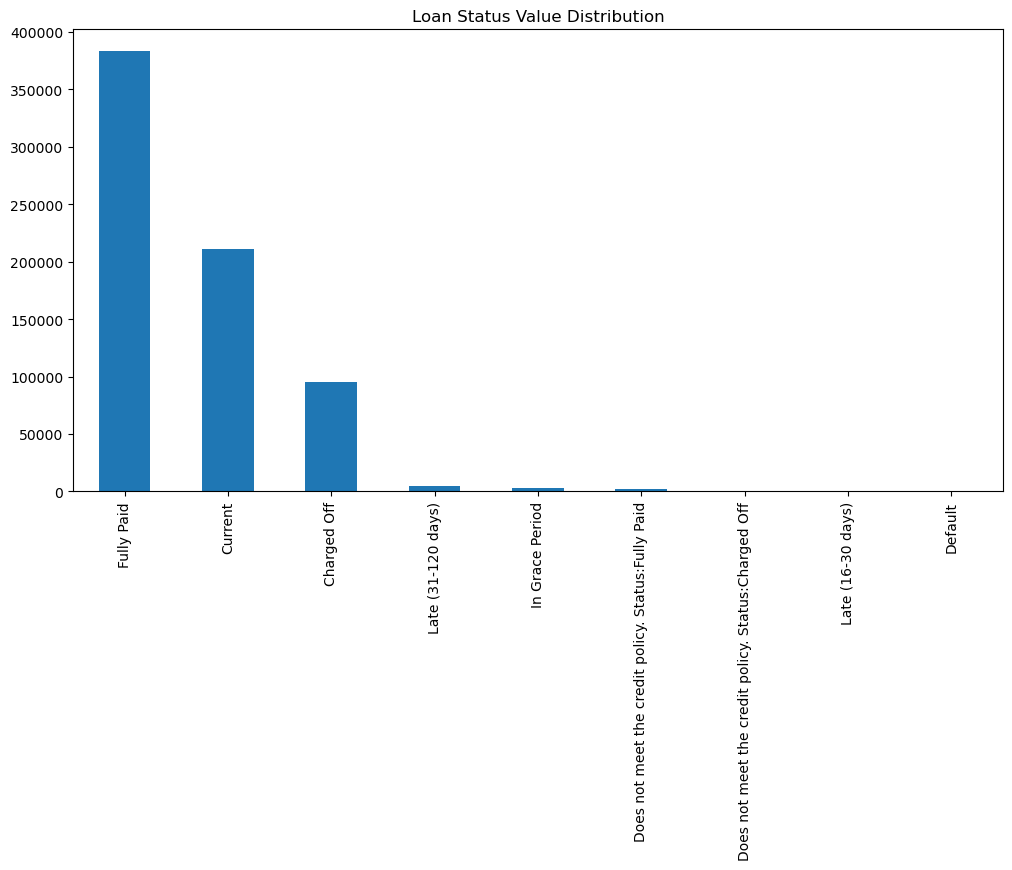

In [12]:
plt.figure(figsize=(12,6))
loan_data.loan_status.value_counts().plot.bar()
plt.title('Loan Status Value Distribution')

In [13]:
# Selecting Fully Paid and Charged Off Rows. 
# For this example we are going to predict only 2 outputs, Fully Paid and Charged Off
loan_data = loan_data.loc[loan_data['loan_status'].isin(['Fully Paid', 'Charged Off'])]
loan_data.shape

(478658, 138)

In [14]:
print(loan_data.loan_status.value_counts())

Fully Paid     383160
Charged Off     95498
Name: loan_status, dtype: int64


In [15]:
# Creating a new column as target, labeling as 0 and 1 as Loan Status

loan_data['loan condition'] = loan_data.loan_status.map({'Fully Paid':0,'Charged Off':1})


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
loan_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,loan condition
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0


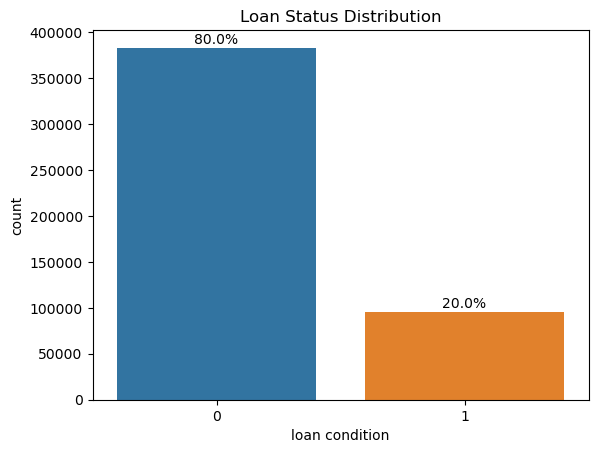

In [17]:
ax = sns.countplot(data = loan_data, x = 'loan condition')
total = len(loan_data)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

plt.title('Loan Status Distribution')
plt.show()

In [18]:
# descriptive analysis
loan_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,478658.0,14354.750156,9049.092931,500.00,7500.00,12000.00,20000.00,4.000000e+04
funded_amnt,478658.0,14331.097986,9038.250337,500.00,7500.00,12000.00,20000.00,4.000000e+04
funded_amnt_inv,478658.0,14278.536436,9049.500059,0.00,7225.00,12000.00,20000.00,4.000000e+04
installment,478658.0,435.492368,268.197087,4.93,239.55,370.91,578.12,1.719830e+03
annual_inc,478658.0,74887.805014,172574.895179,0.00,45000.00,63456.50,90000.00,1.100000e+08
...,...,...,...,...,...,...,...,...
hardship_dpd,2379.0,12.058428,9.668450,0.00,0.00,12.00,20.00,3.400000e+01
orig_projected_additional_accrued_interest,4333.0,130.620540,307.041723,0.00,0.00,0.00,74.02,2.679150e+03
hardship_payoff_balance_amount,4949.0,4963.266710,8312.996291,0.00,0.00,0.00,7507.02,4.030641e+04
hardship_last_payment_amount,4949.0,2122.296696,4234.071551,0.01,165.79,455.68,1548.00,3.127601e+04


In [19]:
# create bins for loan_amnt_range
loan_bin = loan_data['loan_amnt'].value_counts(bins=7).sort_values()
loan_bin

(28714.286, 34357.143]     20631
(34357.143, 40000.0]       24658
(23071.429, 28714.286]     39434
(17428.571, 23071.429]     66432
(460.499, 6142.857]        97173
(11785.714, 17428.571]    103124
(6142.857, 11785.714]     127206
Name: loan_amnt, dtype: int64

In [20]:
# label with the round up numbers
loan_data['loan_amnt_range'] = pd.cut(loan_data['loan_amnt'], bins=7, 
                                 labels=['460-6143', '6143-11786', '11786-17429',
                                         '17429-23071','23071-28714','28714-34357',
                                         '34357-40000'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'Loan Amount Distribution')

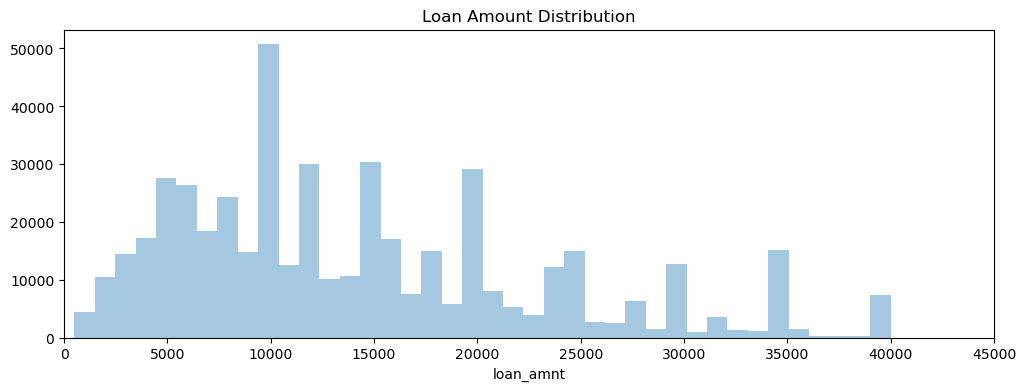

In [21]:
# Loan Amount
plt.figure(figsize=(12,4))
sns.distplot(loan_data['loan_amnt'],kde=False,bins=40)
plt.xlim(0,45000)
plt.title('Loan Amount Distribution')

In [22]:
# create annual_inc_range, based on https://taxsummaries.pwc.com/united-states/individual/taxes-on-personal-income
cat = [(loan_data['annual_inc'] == 0),
    (loan_data['annual_inc']>=1) & (loan_data['annual_inc']<=10275),
    (loan_data['annual_inc']>10276) & (loan_data['annual_inc']<=41775),
    (loan_data['annual_inc']>41776) & (loan_data['annual_inc']<=89075),
    (loan_data['annual_inc']>89076) & (loan_data['annual_inc']<=170050)]
        
brackets = ['0','1 to 10275','10276 to 41775','41776 to 89075','89076 to 170050']
loan_data['annual_inc_range'] = np.select(cat, brackets)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Annual income range (USD)')

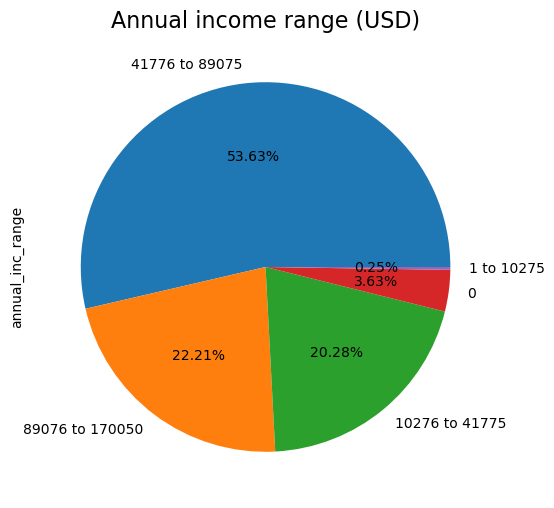

In [23]:
# plot with figures transformed into percentage
loan_data['annual_inc_range'].value_counts().plot.pie(autopct='%.2f%%', figsize=(15, 6))
plt.title('Annual income range (USD)', fontsize=16) 

In [24]:
# remove '%' and convert 'interest' into numeric type
loan_data['int_rate'] = loan_data['int_rate'].str.replace('%','')
loan_data['int_rate'] = pd.to_numeric(loan_data['int_rate'])
loan_data['int_rate'].head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    10.65
1    15.27
2    15.96
3    13.49
4    12.69
Name: int_rate, dtype: float64

In [25]:
# create bins for int_rate_range
int_bin = loan_data['int_rate'].value_counts(bins=5).sort_values(ascending=True)
int_bin

(25.854, 30.99]                   8223
(20.718, 25.854]                 32564
(15.582, 20.718]                106889
(5.2829999999999995, 10.446]    146972
(10.446, 15.582]                184010
Name: int_rate, dtype: int64

In [26]:
# labels with rounded figures 
loan_data['int_rate_range'] = pd.cut(loan_data['int_rate'], 
                                 bins=5, 
                                 labels=['5.2-10.4','10.4-15.5','15.5-20.7','20.7-25.8','25.8-31'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 0, 'Percentage (%)')

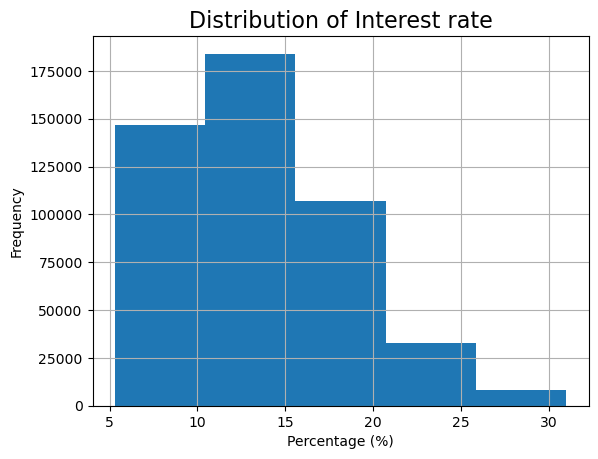

In [27]:
# histogram
loan_data['int_rate'].hist(bins=5)
plt.title('Distribution of Interest rate', fontsize=16)
plt.ylabel("Frequency")
plt.xlabel("Percentage (%)")

In [28]:
# examine the difference between fico_range_high and fico_range_low
loan_data['fico_range'] = loan_data['fico_range_high'] + loan_data['fico_range_low']/2
loan_data['fico_range'].head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    1106.5
1    1114.0
2    1106.5
3    1039.0
4    1046.5
Name: fico_range, dtype: float64

In [29]:
# convert FICO scores into categories

## conditions
conditions = [(loan_data['fico_range']<580),
    (loan_data['fico_range']>580) & (loan_data['fico_range']<=669),
    (loan_data['fico_range']>669) & (loan_data['fico_range']<=739),
    (loan_data['fico_range']>739) & (loan_data['fico_range']<=799),
    (loan_data['fico_range']>=800)]

## categories
rating = ['Poor', 'Fair', 'Good', 'Very_good', 'Exceptional']

## return an array drawn from 2 lists, and add the new column to df
loan_data['fico_rating'] = np.select(conditions, rating)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.5, 'Frequency')

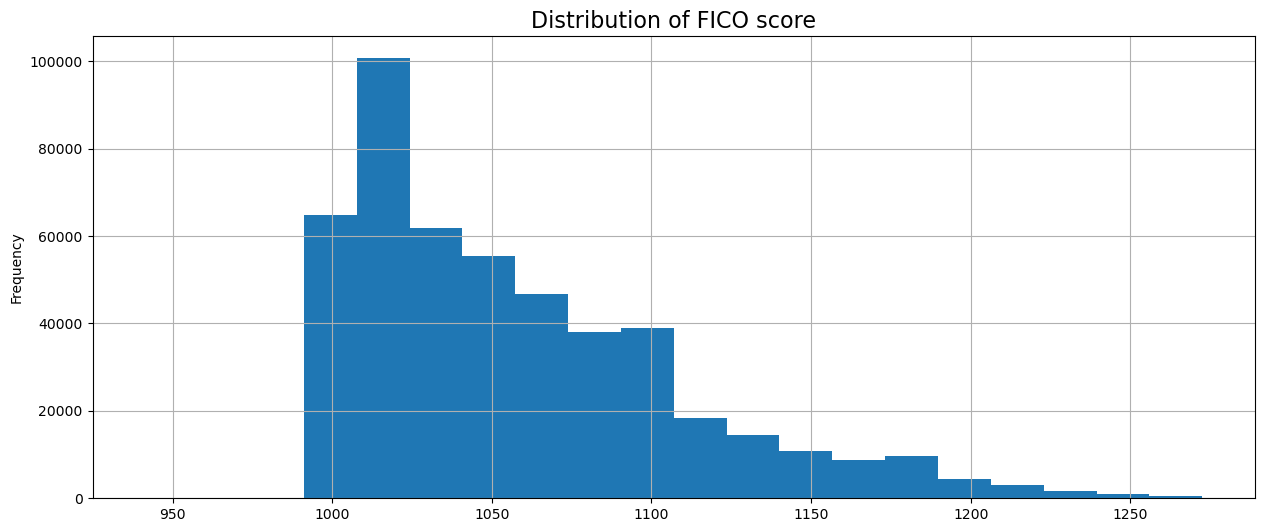

In [30]:
# histogram
loan_data['fico_range'].hist(bins=20, figsize=(15, 6))
plt.title('Distribution of FICO score', fontsize=16)
plt.ylabel('Frequency')

In [31]:
# drop the features which no longer needed
loan_data.drop(columns=['fico_range_low','fico_range_high'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Loan term')

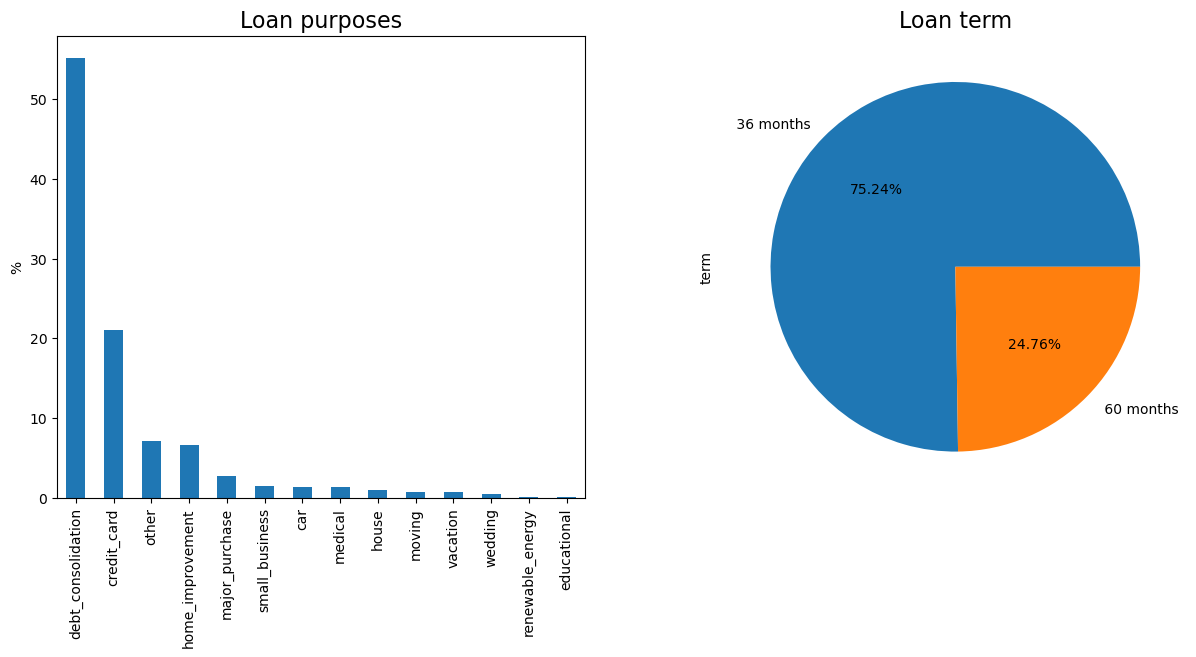

In [32]:
# Categorical data
# Features are presented side be side but it is for optimal layout, not checking their mutual relationship.

# purpose and term

fig, axs = plt.subplots(1,2 , figsize=(15, 6))
# bar chart
loan_data['purpose'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[0])
axs[0].set_title('Loan purposes', fontsize=16)
axs[0].set_ylabel("%")

# pie chart
loan_data['term'].value_counts().plot.pie(ax=axs[1], autopct='%.2f%%')
axs[1].set_title('Loan term', fontsize=16)

In [33]:
# grade and sub-grade
loan_data['grade'].unique()


array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [34]:
loan_data['sub_grade'].unique()

array(['B2', 'C4', 'C5', 'C1', 'B5', 'A4', 'E1', 'F2', 'C3', 'B1', 'D1',
       'A1', 'B3', 'B4', 'C2', 'D2', 'A3', 'A5', 'D5', 'A2', 'E4', 'D3',
       'D4', 'F3', 'E3', 'F4', 'F1', 'E5', 'G4', 'E2', 'G3', 'G2', 'G1',
       'F5', 'G5'], dtype=object)

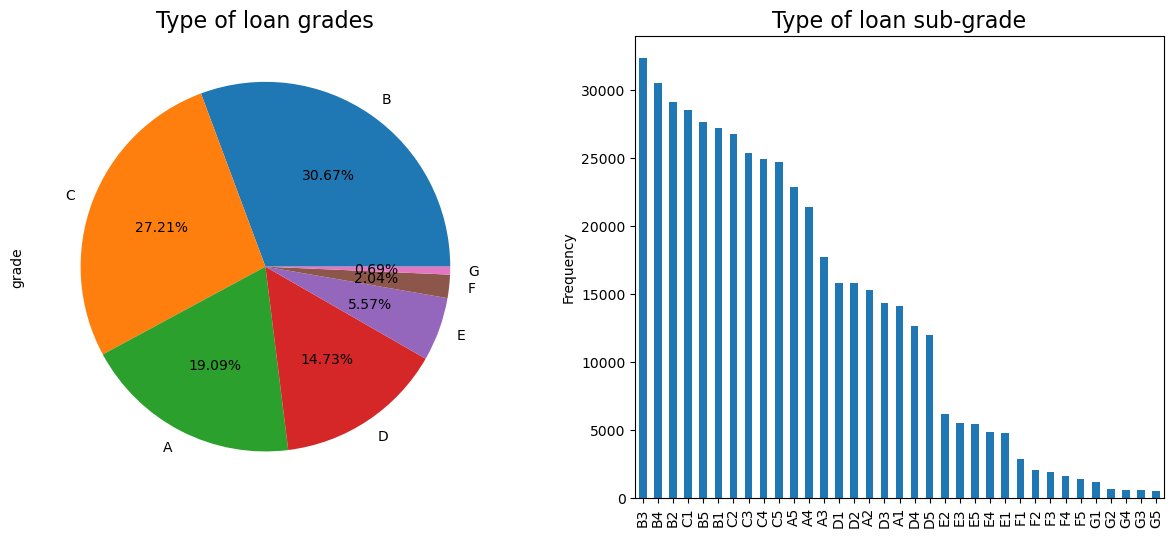

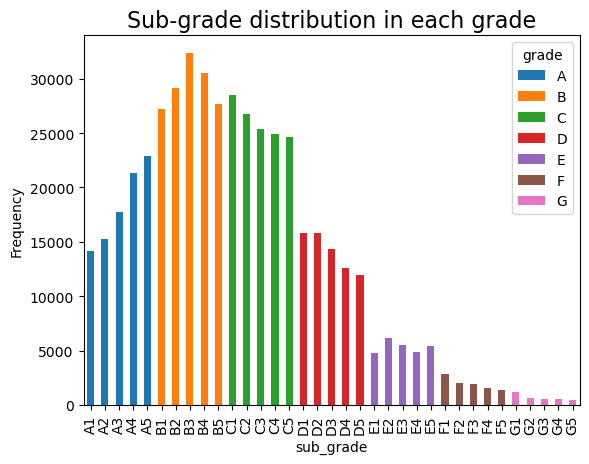

In [35]:
# grade and sub-grade

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# grade
loan_data['grade'].value_counts().plot.pie(ax=axs[0], autopct='%.2f%%')
axs[0].set_title('Type of loan grades', fontsize=16)

# sub-grade
loan_data['sub_grade'].value_counts().plot.bar(ax=axs[1])
axs[1].set_title('Type of loan sub-grade', fontsize=16)
axs[1].set_ylabel('Frequency')
plt.show()

#### Grade vs sub_grade, using crosstab function to count the frequency
pd.crosstab(loan_data['sub_grade'], loan_data['grade']).plot(kind='bar', stacked=True)
plt.title('Sub-grade distribution in each grade', fontsize=16)
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, '%')

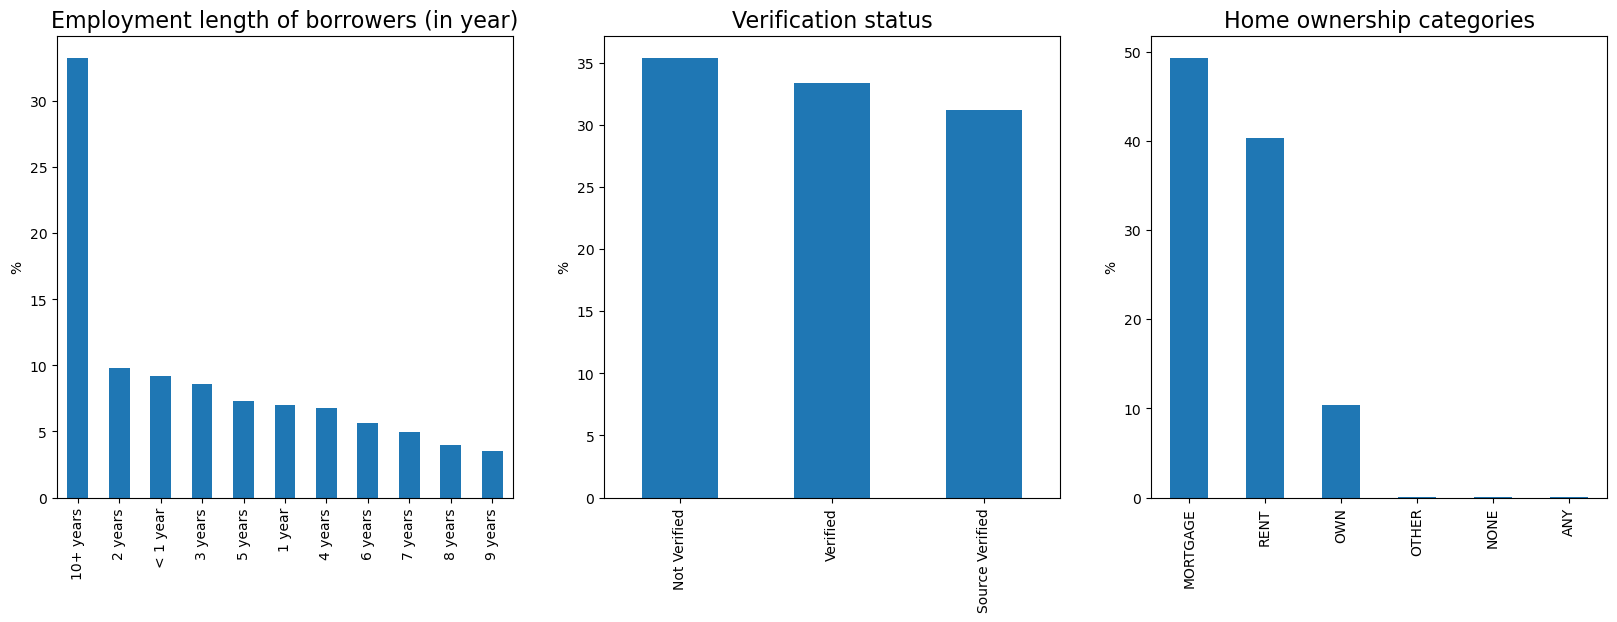

In [36]:
# emp_length, home ownership, and verification status
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# employment length plot
loan_data['emp_length'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[0])
axs[0].set_title('Employment length of borrowers (in year)', fontsize=16)
axs[0].set_ylabel("%")

# verification status plot
loan_data['verification_status'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[1])
axs[1].set_title('Verification status', fontsize=16)
axs[1].set_ylabel("%")

# Home ownership plot
loan_data['home_ownership'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[2])
axs[2].set_title('Home ownership categories', fontsize=16)
axs[2].set_ylabel("%")

# all the units ae percentage

In [37]:
# filter out the applicants who have Not Verified status for their income 
vf = loan_data[(loan_data.verification_status == 'Not Verified')]

# present in transposed style
vf.head().T 

,2,6,10,15,16
loan_amnt,2400.0,7000.0,6500.0,1000.0,10000.0
funded_amnt,2400.0,7000.0,6500.0,1000.0,10000.0
funded_amnt_inv,2400.0,7000.0,6500.0,1000.0,10000.0
term,36 months,60 months,60 months,36 months,36 months
int_rate,15.96,15.96,14.65,16.29,15.27
...,...,...,...,...,...
loan_amnt_range,460-6143,6143-11786,6143-11786,460-6143,6143-11786
annual_inc_range,10276 to 41775,41776 to 89075,41776 to 89075,10276 to 41775,41776 to 89075
int_rate_range,15.5-20.7,15.5-20.7,10.4-15.5,15.5-20.7,10.4-15.5
fico_range,1106.5,1039.0,1046.5,1001.5,1009.0


Text(0.5, 1.0, 'Application type')

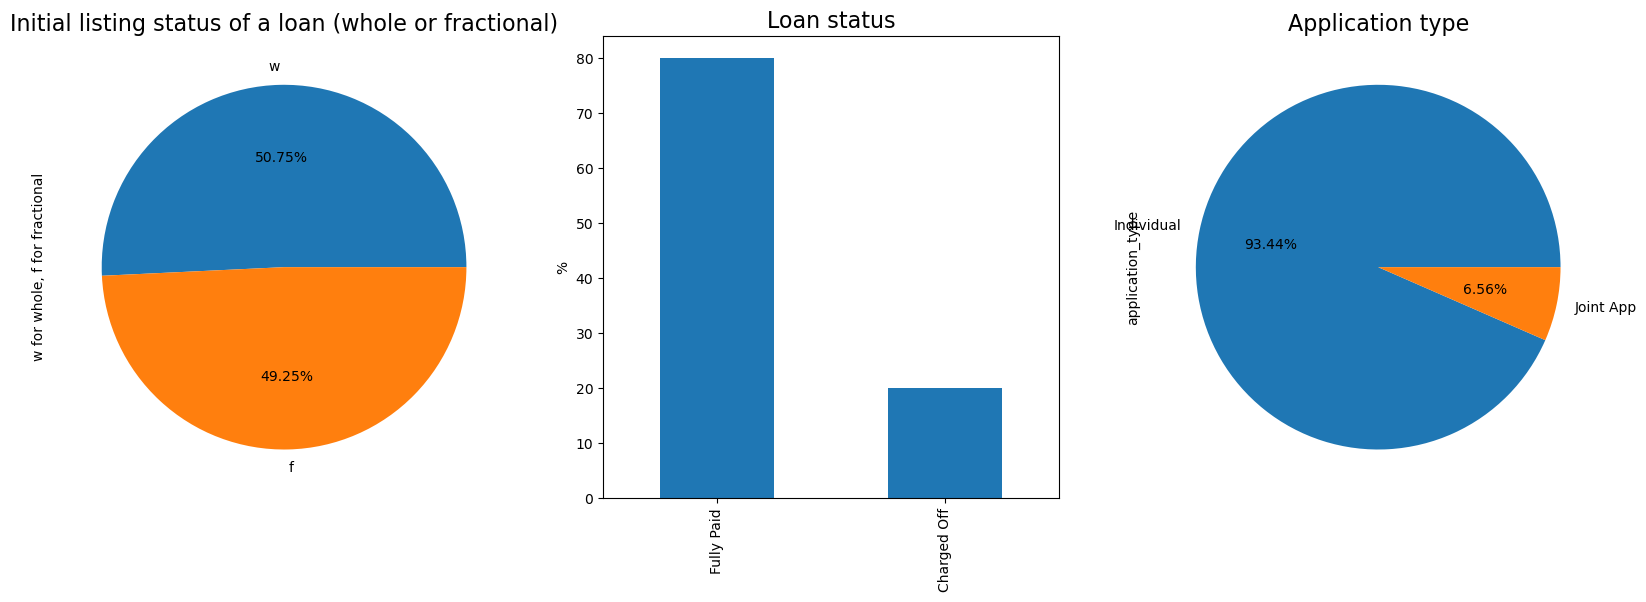

In [38]:
# initial_list_status, loan_status and application_type

# the graphs for "initial list status", "loan status" and "application type" are plotted below
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# 1st graph
loan_data['initial_list_status'].value_counts().plot.pie(ax=axs[0],autopct='%.2f%%')
axs[0].set_title('Initial listing status of a loan (whole or fractional)', fontsize=16)
axs[0].set_ylabel("w for whole, f for fractional")

# 2nd graphs
loan_data['loan_status'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[1])
axs[1].set_title('Loan status', fontsize=16)
axs[1].set_ylabel("%")

# 3rd graph
loan_data['application_type'].value_counts().plot.pie(ax=axs[2],autopct='%.2f%%')
axs[2].set_title('Application type', fontsize=16)

Text(0.5, 0, 'state')

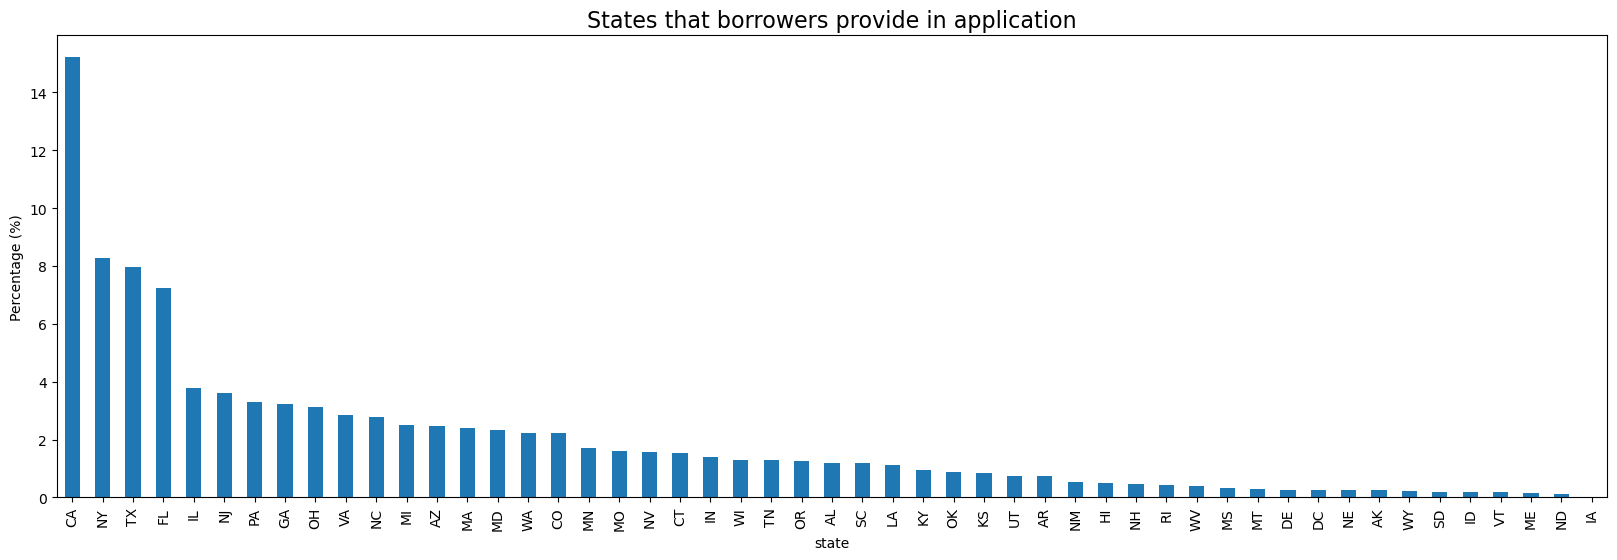

In [39]:
# addr_state and emp_title

# count the frequency of states where the applicants live in  
loan_data['addr_state'].value_counts(normalize=True).mul(100).plot.bar(figsize=(20, 6))
plt.title('States that borrowers provide in application', fontsize=16)
plt.ylabel("Percentage (%)")
plt.xlabel("state")

In [40]:
#the "employment title" shows what employment position most of the borrowers hold
loan_data['emp_title'].value_counts(ascending=True)

Cliffs Natural Resources LLc       1
Masa's Sushi                       1
West Valley Staffing Group         1
NYS Queens Supreme Court           1
Durie Tangri LLP                   1
                                ... 
Registered Nurse                2047
Driver                          2526
Owner                           3198
Manager                         5188
Teacher                         5194
Name: emp_title, Length: 204375, dtype: int64

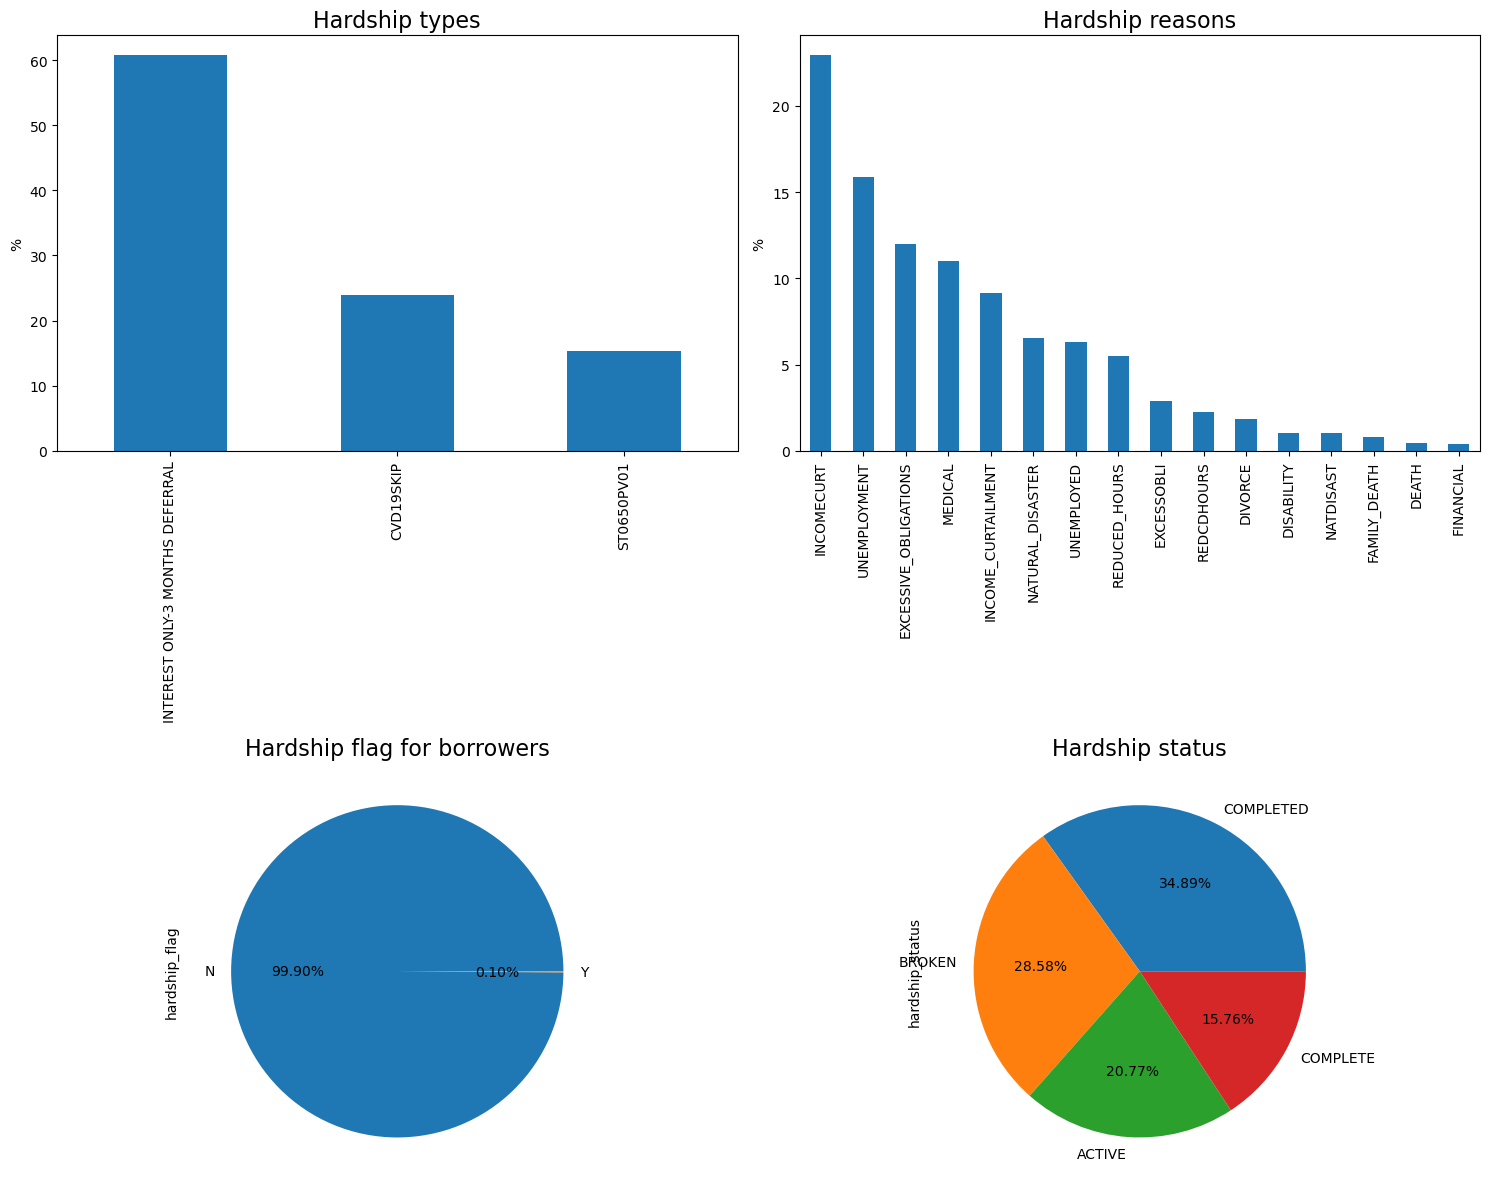

In [41]:
# Related to hardship

# Plot hardship_type, hardship_reason, and hardship_flag
fig, axs = plt.subplots(2, 2, figsize=(15,12))

# 1st plot
loan_data['hardship_type'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[0,0])
axs[0,0].set_title('Hardship types', fontsize=16)
axs[0,0].set_ylabel("%")

# 2nd plot
loan_data['hardship_reason'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[0,1])
axs[0,1].set_title('Hardship reasons', fontsize=16)
axs[0,1].set_ylabel("%")

# 3rd plot
loan_data['hardship_flag'].value_counts().plot.pie(ax=axs[1,0], autopct='%.2f%%')
axs[1,0].set_title('Hardship flag for borrowers', fontsize=16)

# 4th plot
loan_data['hardship_status'].value_counts().plot.pie(ax=axs[1,1], autopct='%.2f%%')
axs[1,1].set_title('Hardship status', fontsize=16)
plt.tight_layout()

In [42]:
# Bivariate EDA
# In this part we will try to answer some questions related to the relationship between 2 variables.

# Loan status
# loan_status and term

# create a crosstab to count the frequency of terms in each loan status
pd.crosstab(loan_data['loan_status'], loan_data['term'], normalize="index").mul(100)
# unit: percentage

term,36 months,60 months
loan_status,,
Charged Off,61.415946,38.584054
Fully Paid,78.679403,21.320597


Text(0, 0.5, '%')

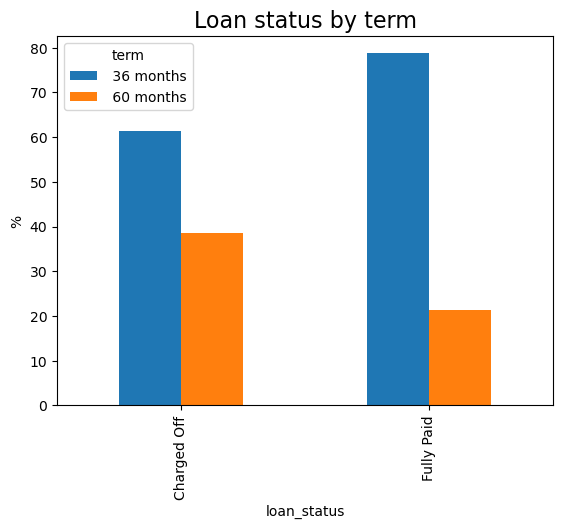

In [43]:
# visualize from crosstab
pd.crosstab(loan_data['loan_status'], loan_data['term'], normalize="index").mul(100).plot(kind='bar')
plt.title('Loan status by term', fontsize=16)
plt.ylabel('%')

Text(0, 0.5, 'Percentage (%)')

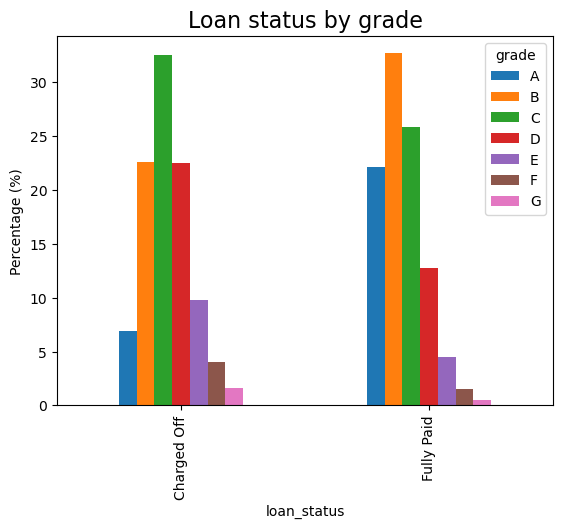

In [44]:
# loan_status and grade

# the frequency of crosstab already converted into percentage
pd.crosstab(loan_data['loan_status'], loan_data['grade'], normalize='index').mul(100).plot(kind='bar', stacked=False)
plt.title('Loan status by grade', fontsize=16)
plt.ylabel('Percentage (%)')

In [45]:
# loan_status and home_ownership

# create crosstab with normalized data in each loan status
pd.crosstab(loan_data['loan_status'], loan_data['home_ownership'], normalize='index').mul(100)
# unit: percentage

home_ownership,ANY,MORTGAGE,NONE,OTHER,OWN,RENT
loan_status,,,,,,
Charged Off,0.004189,42.737021,0.007330,0.028273,11.094473,46.128715
Fully Paid,0.003393,50.971657,0.010179,0.030536,10.154766,38.829471


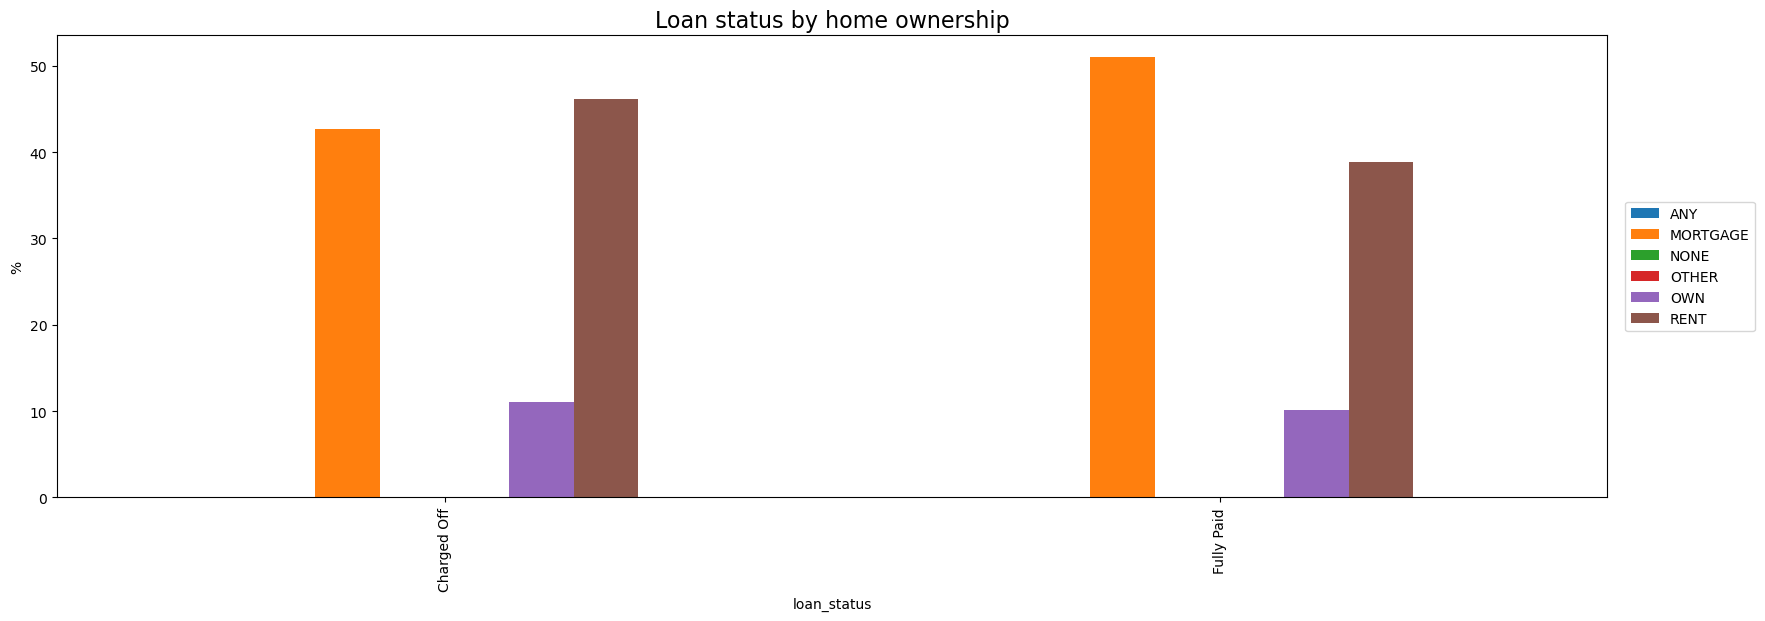

In [46]:
# visualize from the crosstab table
pd.crosstab(loan_data['loan_status'], loan_data['home_ownership'], normalize='index').mul(100).plot(kind='bar', figsize=(20, 6))
plt.title('Loan status by home ownership', fontsize=16)
plt.ylabel('%')
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='right')

In [47]:
# loan_status and verification_status
# create crosstab with normalized data in each loan status
pd.crosstab(loan_data['loan_status'], loan_data['verification_status'], normalize='index').mul(100)

verification_status,Not Verified,Source Verified,Verified
loan_status,,,
Charged Off,28.170223,33.967204,37.862573
Fully Paid,37.223875,30.503967,32.272158


Text(0, 0.5, '%')

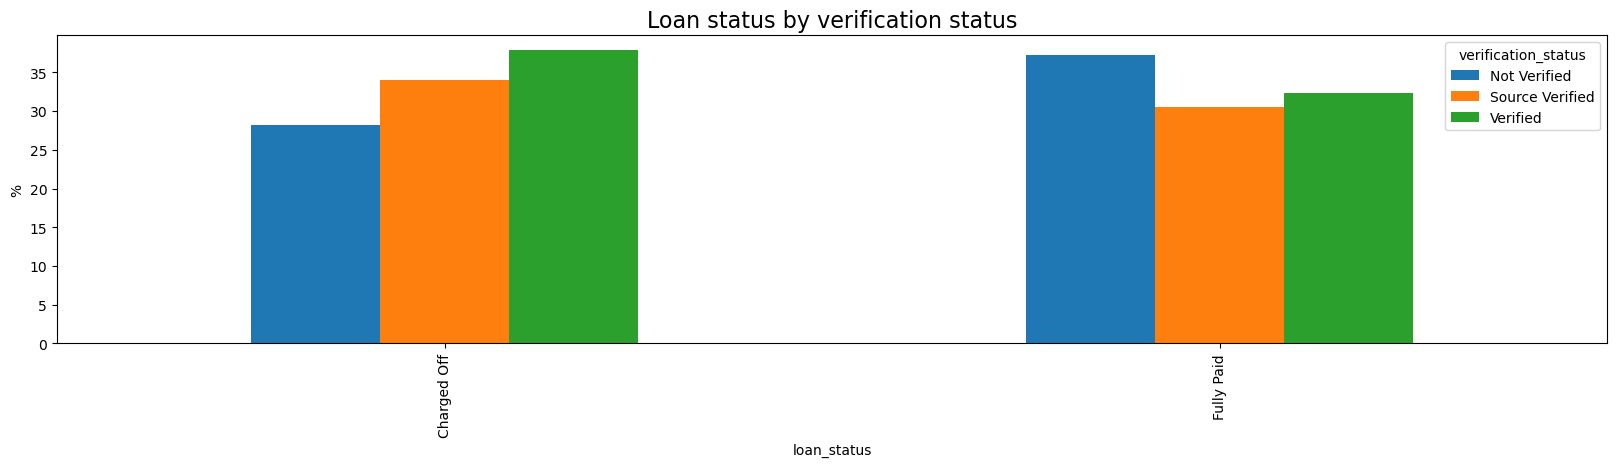

In [48]:
# visualize
pd.crosstab(loan_data['loan_status'], loan_data['verification_status'], normalize='index').mul(100).plot(kind='bar', figsize=(20, 4))
plt.title('Loan status by verification status', fontsize=16)
plt.ylabel('%')

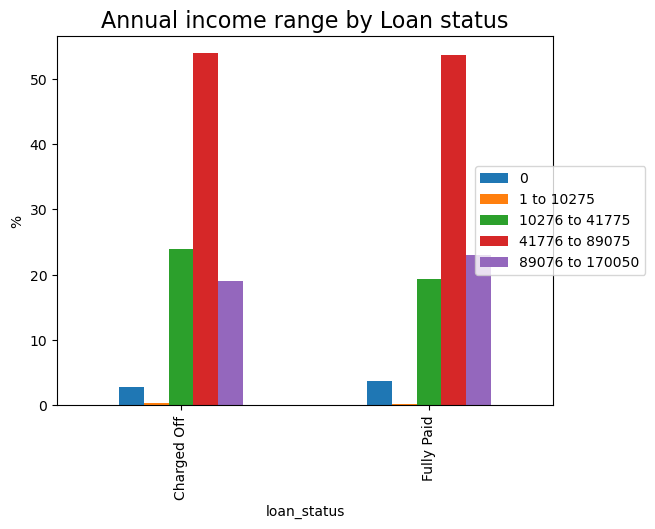

In [49]:
# loan_status and annual_inc_range, emp_length, and purpose
# Loan status and annual income range
pd.crosstab(loan_data['loan_status'], loan_data['annual_inc_range'], normalize='index').mul(100).plot(kind='bar')
plt.title('Annual income range by Loan status', fontsize=16)
plt.ylabel("%")
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='right')

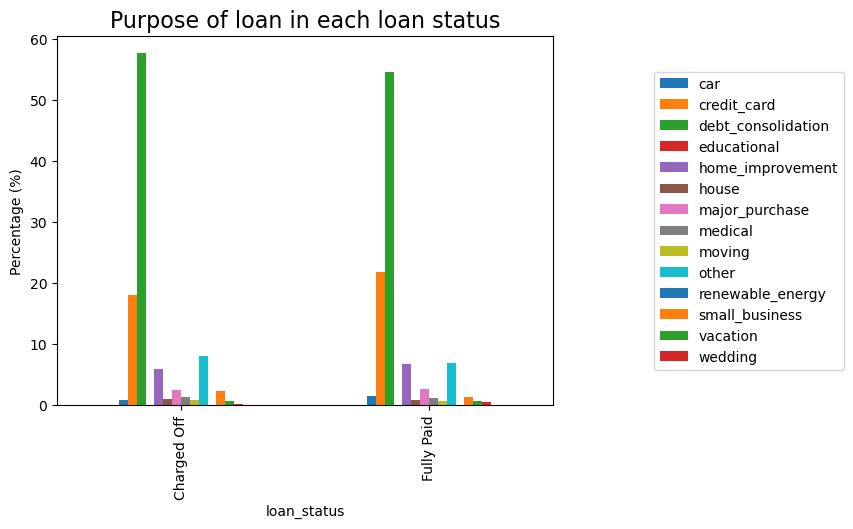

In [50]:
# loan status and purposes
pd.crosstab(loan_data['loan_status'], loan_data['purpose'], normalize='index').mul(100).plot(kind='bar')
plt.title('Purpose of loan in each loan status', fontsize=16)
plt.ylabel("Percentage (%)")
plt.legend(bbox_to_anchor=(1.6, 0.5), loc='right')

Text(0.5, 0.98, 'Distribution of Annual income range, Employment length and Purpose in Charged Off status (respectively)')

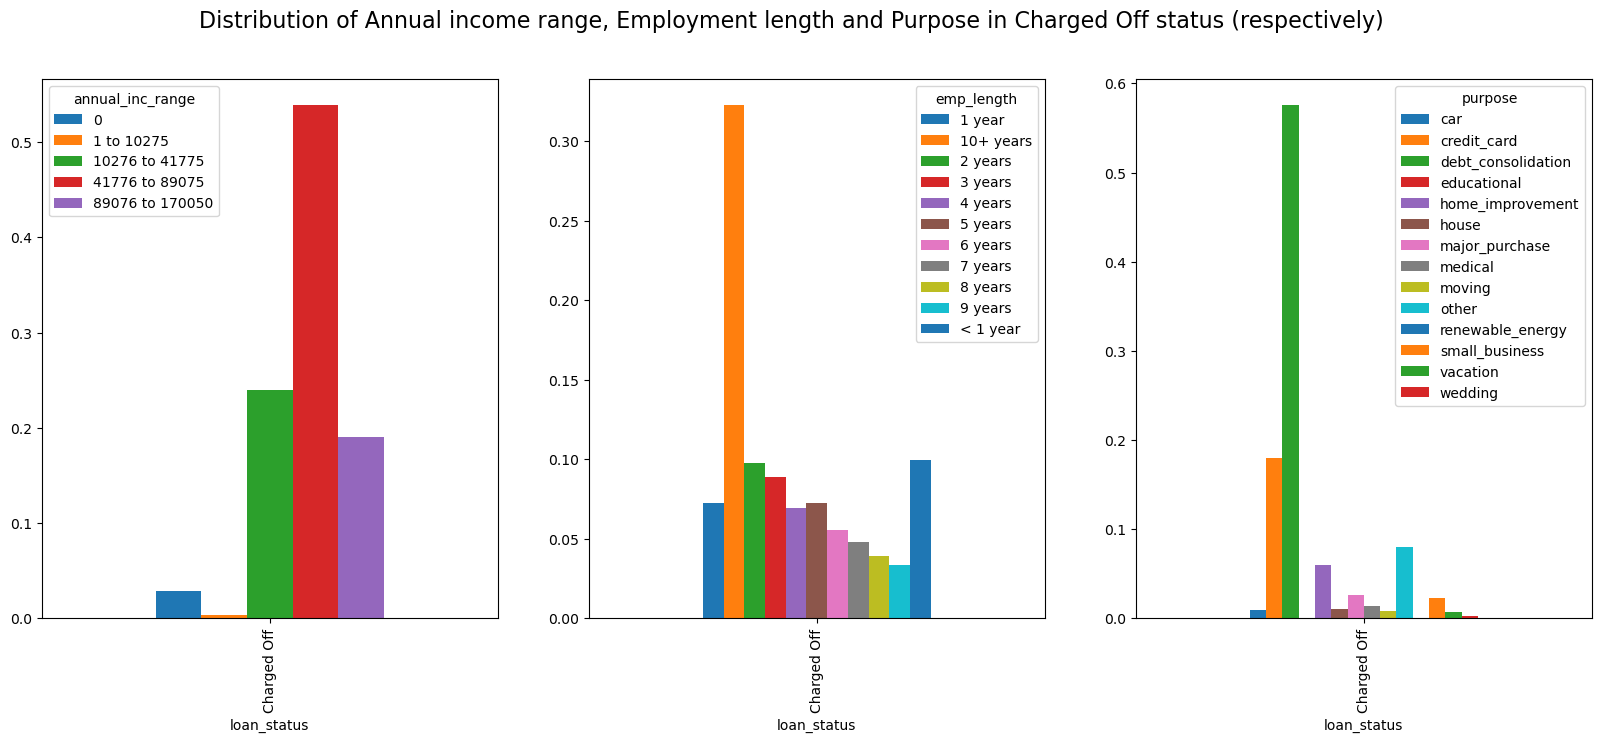

In [51]:
# a closer look at Charged Off status only
fig, axs = plt.subplots(1, 3, figsize=(20, 7), sharex=True)
pd.crosstab(loan_data['loan_status'], loan_data['annual_inc_range'], normalize='index').filter(items=['Charged Off'], axis=0).plot(kind='bar',ax=axs[0])
pd.crosstab(loan_data['loan_status'], loan_data['emp_length'], normalize='index').filter(items=['Charged Off'], axis=0).plot(kind='bar',ax=axs[1])
pd.crosstab(loan_data['loan_status'], loan_data['purpose'], normalize='index').filter(items=['Charged Off'], axis=0).plot(kind='bar',ax=axs[2])
fig.suptitle('Distribution of Annual income range, Employment length and Purpose in Charged Off status (respectively)', fontsize=16)

In [52]:
# we take a look at only Charged Off and Fully Paid in loan status.

# create cross table with normalized values
df_1 = pd.crosstab(loan_data['loan_status'], loan_data['open_acc'], normalize='index').mul(100).sort_values(axis=1, by='Charged Off', ascending=False)
df_2 = pd.crosstab(loan_data['loan_status'], loan_data['total_acc'], normalize='index').mul(100).sort_values(axis=1, by='Charged Off', ascending=False)


Text(0, 0.5, 'Frequency')

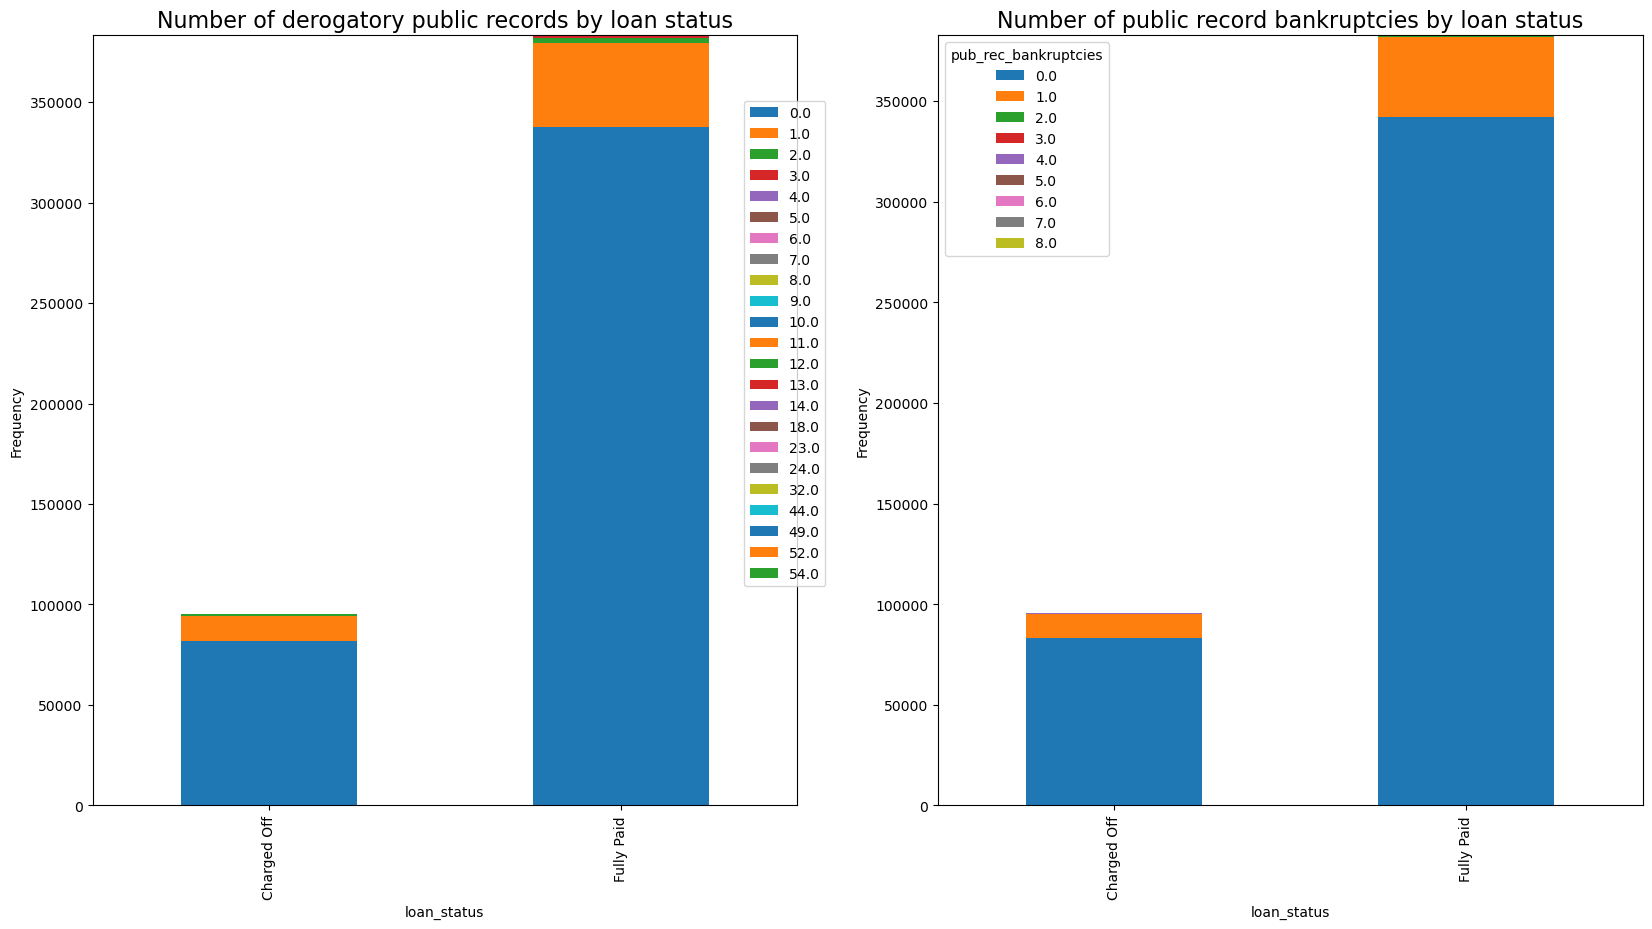

In [53]:
# loan_status and pub_rec/ pub_rec_bankruptcies
fig, axs = plt.subplots(1, 2, figsize=(20, 10)) 

# loan status and number of derogatory public records
pd.crosstab(loan_data['loan_status'], loan_data['pub_rec']).plot(kind='bar',ax=axs[0], stacked=True)
axs[0].set_title('Number of derogatory public records by loan status', fontsize=16)
axs[0].set_ylabel("Frequency")
axs[0].legend(bbox_to_anchor=(1.05, 0.6), loc='right')

# loan status and number of public record bankruptcies
pd.crosstab(loan_data['loan_status'], loan_data['pub_rec_bankruptcies']).plot(kind='bar',ax=axs[1], stacked=True)
axs[1].set_title('Number of public record bankruptcies by loan status', fontsize=16)
axs[1].set_ylabel("Frequency")

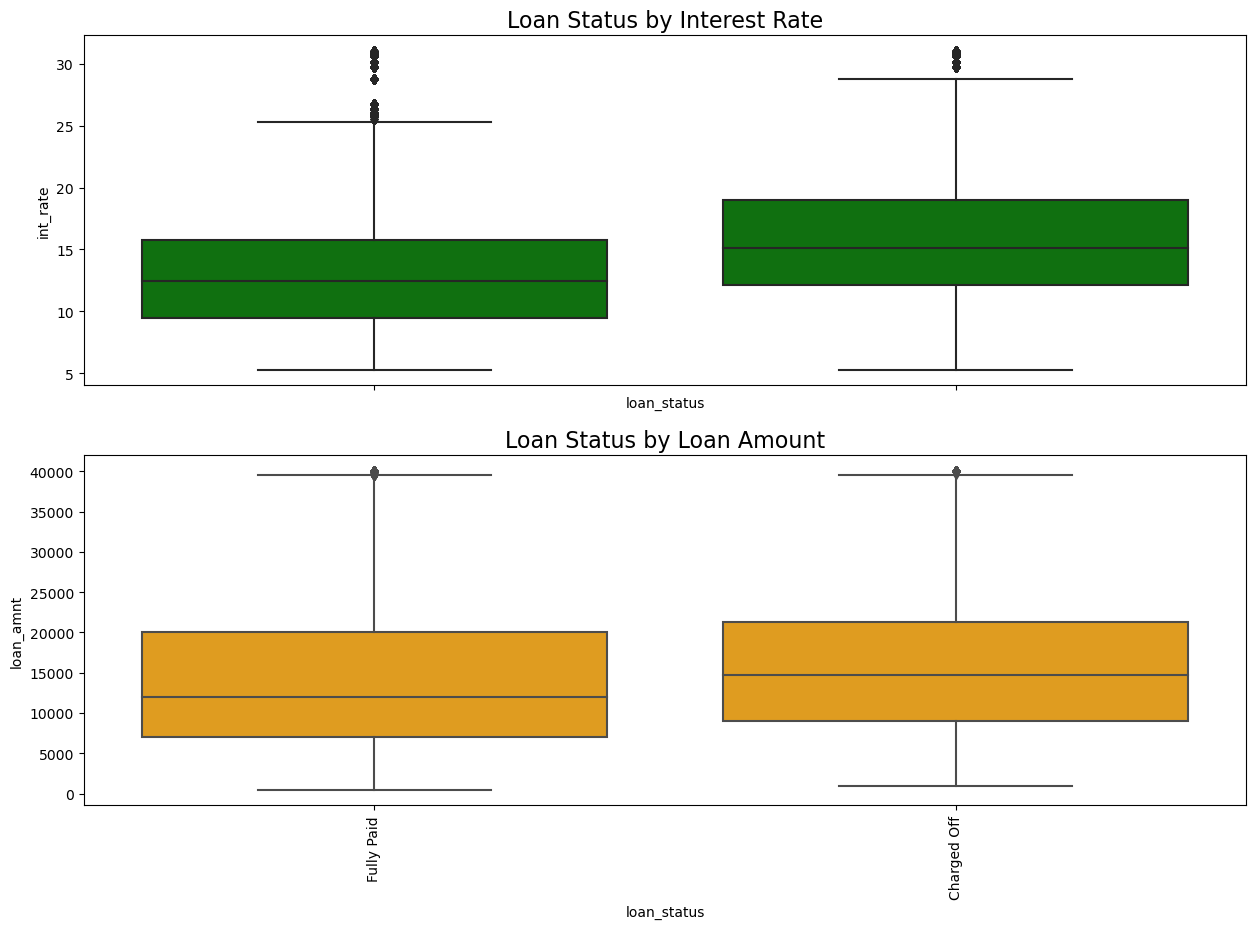

In [54]:
# Loan status and interest rate / loan amount
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# loan status and interest rate
sns.boxplot(x="loan_status", y="int_rate", data=loan_data, color='g', ax=axs[0])
axs[0].set_title('Loan Status by Interest Rate', fontsize=16)

# loan status and loan amount
sns.boxplot(x="loan_status", y="loan_amnt", data=loan_data, color='orange', ax=axs[1])
axs[1].set_title('Loan Status by Loan Amount', fontsize=16)
axs[1].tick_params(axis='x', rotation=90)

In [55]:
# Loan status per state
# create crosstab
df_st = pd.crosstab(loan_data['loan_status'], loan_data['addr_state'], normalize='index')

In [56]:
#  Loan amount
#  Loan amount vs year experience
# crosstab table that count frequency of employment length per loan amount range
# unit: percentage
df_emp = pd.crosstab(loan_data['loan_amnt_range'], loan_data['emp_length'], normalize='index').mul(100)
df_emp

emp_length,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
loan_amnt_range,,,,,,,,,,,
460-6143,8.488498,28.232476,11.315361,9.495187,7.435486,7.402721,5.437927,4.544222,3.701360,3.090116,10.856646
6143-11786,7.567645,30.055566,10.629274,9.190789,7.157854,7.781816,5.885478,5.025422,3.944451,3.480695,9.281010
11786-17429,6.638428,33.907629,9.408523,8.504210,6.671090,7.529472,5.640214,5.265629,4.181679,3.768308,8.484818
17429-23071,6.074545,37.316641,8.635243,7.720030,6.104578,6.954982,5.820056,5.247850,4.270991,3.822079,8.033005
23071-28714,5.720709,39.825443,8.034911,7.476858,5.908490,6.725734,5.387464,4.927268,3.885216,3.800582,8.307326
28714-34357,5.778023,39.792996,8.375622,7.345626,5.853389,6.471386,5.094709,4.712857,3.602472,3.547204,9.425715
34357-40000,5.670665,39.015183,8.308867,7.935576,6.337556,6.320778,4.798255,4.458519,3.745491,3.514806,9.894304


Text(0.5, 1.0, 'Loan amount distribution by term')

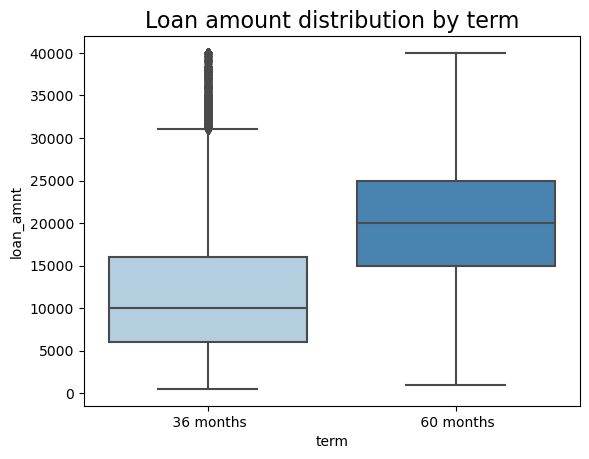

In [57]:
# Loan amount and term
# plot using sns box plot
sns.boxplot(x='term', y='loan_amnt', data=loan_data, palette="Blues")
plt.title('Loan amount distribution by term', fontsize=16)

Text(0, 0.5, '%')

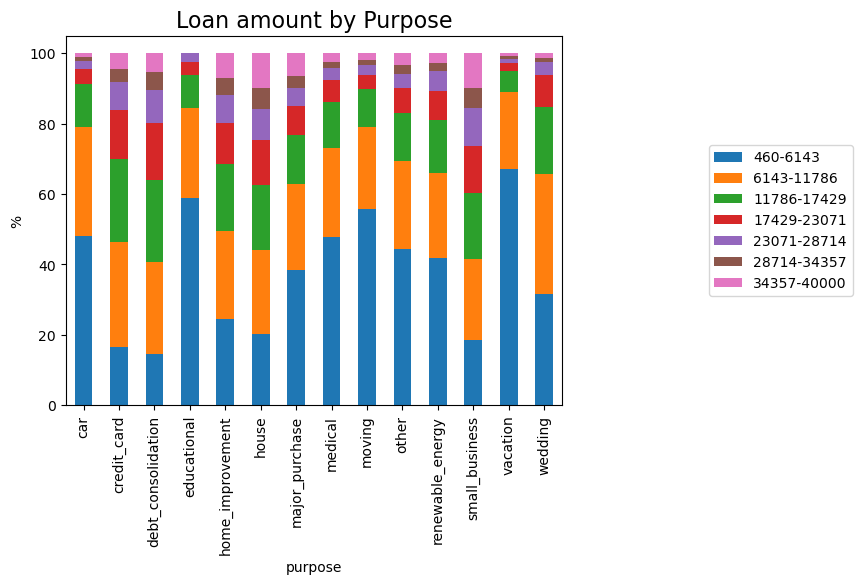

In [58]:
# Loan amount and purpose
# plot graph using crosstab
pd.crosstab(loan_data['purpose'], loan_data['loan_amnt_range'], normalize='index').mul(100).plot(kind='bar', stacked=True)
plt.title('Loan amount by Purpose', fontsize=16)
plt.legend(bbox_to_anchor=(1.6, 0.5), loc='right')
plt.ylabel('%')

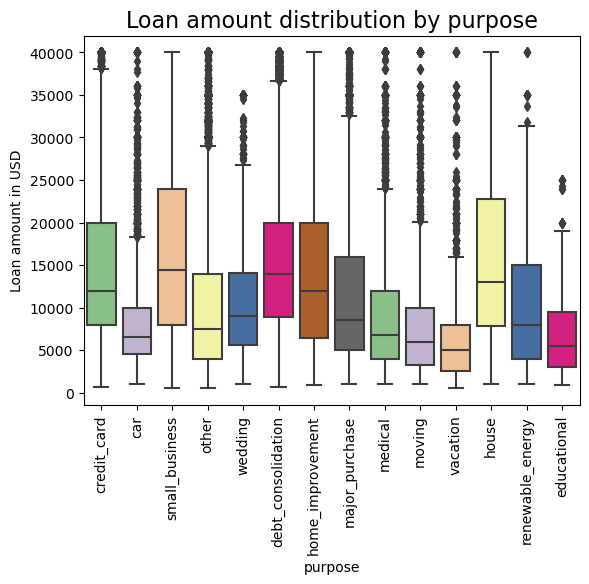

In [59]:
# distribution plot 
sns.boxplot(x='purpose', y='loan_amnt', data=loan_data, palette="Accent")
plt.title("Loan amount distribution by purpose", fontsize=16)
plt.ylabel('Loan amount in USD')
plt.tick_params(axis='x', rotation=90)

Text(0, 0.5, '%')

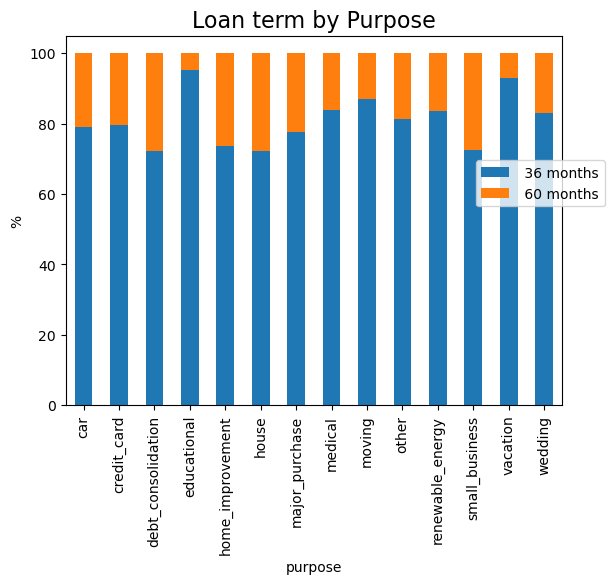

In [60]:
# Purpose
# Purpose and term
# plot from crosstab
pd.crosstab(loan_data['purpose'], loan_data['term'], normalize='index').mul(100).plot(kind='bar', stacked=True)
plt.title('Loan term by Purpose', fontsize=16)
plt.legend(bbox_to_anchor=(1.1, 0.6), loc='right')
plt.ylabel('%')

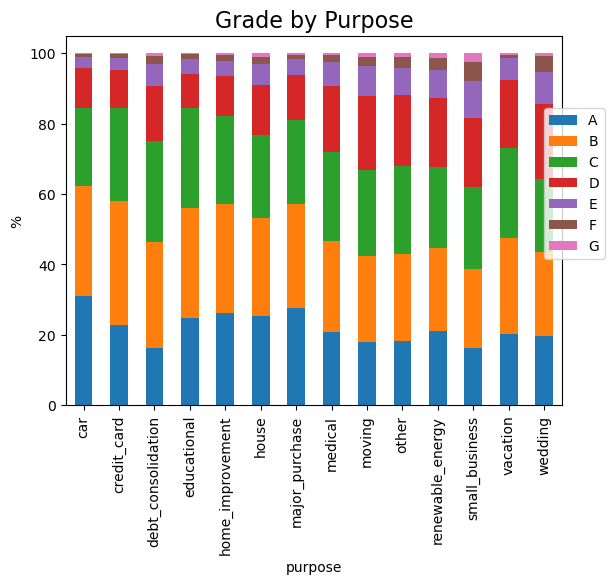

In [61]:
# Purpose and grade
# purposes of loan and loan grades
pd.crosstab(loan_data['purpose'], loan_data['grade'], normalize='index').mul(100).plot(kind='bar', stacked=True)
plt.title('Grade by Purpose', fontsize=16)
plt.ylabel('%')
plt.legend(bbox_to_anchor=(1.1, 0.6), loc='right')

Text(0, 0.5, '%')

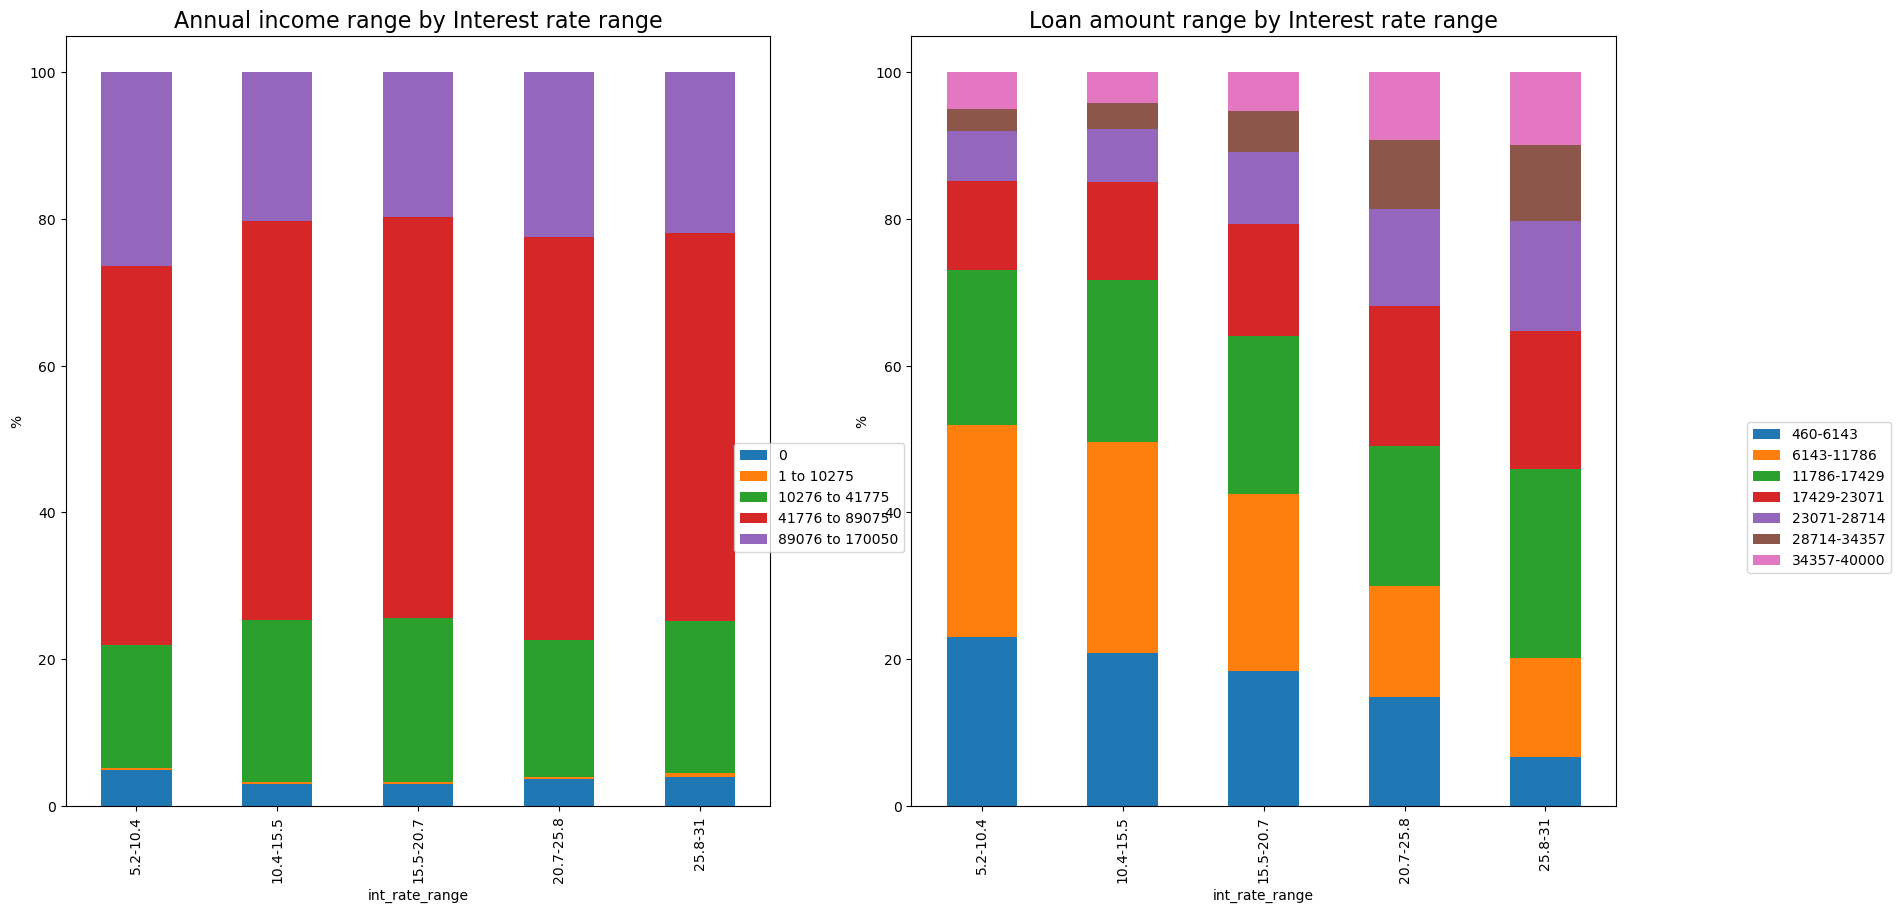

In [62]:
# Interest rate
# Interest rate and annual income
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# interest rate range and annual income range
pd.crosstab(loan_data['int_rate_range'], loan_data['annual_inc_range'], normalize='index').mul(100).plot(kind='bar', ax=axs[0], stacked=True)
axs[0].set_title('Annual income range by Interest rate range', fontsize=16)
axs[0].legend(bbox_to_anchor=(1.2, 0.4), loc='right')
axs[0].set_ylabel('%')

# Loan amount range and interest rate range
pd.crosstab(loan_data['int_rate_range'], loan_data['loan_amnt_range'], normalize='index').mul(100).plot(kind='bar', ax=axs[1], stacked=True)
axs[1].set_title('Loan amount range by Interest rate range', fontsize=16)
axs[1].legend(bbox_to_anchor=(1.4, 0.4), loc='right')
axs[1].set_ylabel('%')

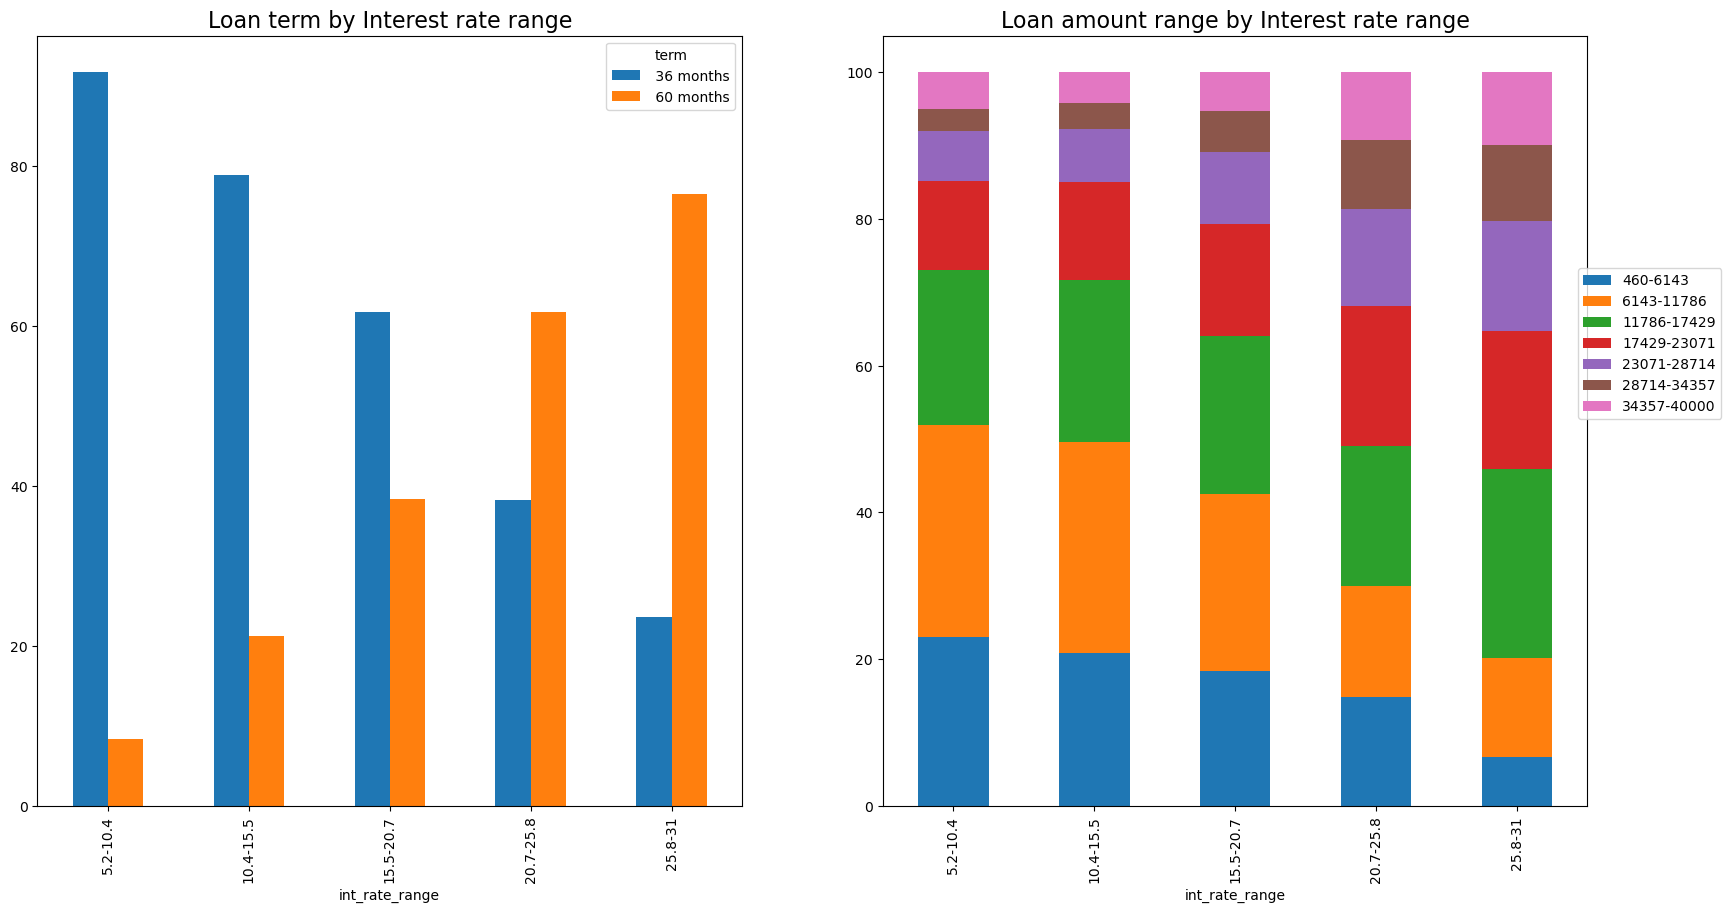

In [63]:
#  Interest rate and term
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# plot
pd.crosstab(loan_data['int_rate_range'], loan_data['term'], normalize='index').mul(100).plot(kind='bar', ax=axs[0], stacked=False)
pd.crosstab(loan_data['int_rate_range'], loan_data['loan_amnt_range'], normalize='index').mul(100).plot(kind='bar', ax=axs[1], stacked=True)

# set titles
axs[0].set_title('Loan term by Interest rate range', fontsize=16)
axs[1].set_title('Loan amount range by Interest rate range', fontsize=16)
axs[1].legend(bbox_to_anchor=(1.2, 0.6), loc='right')

Text(0.5, 1.0, 'Interest rate distribution by Grade')

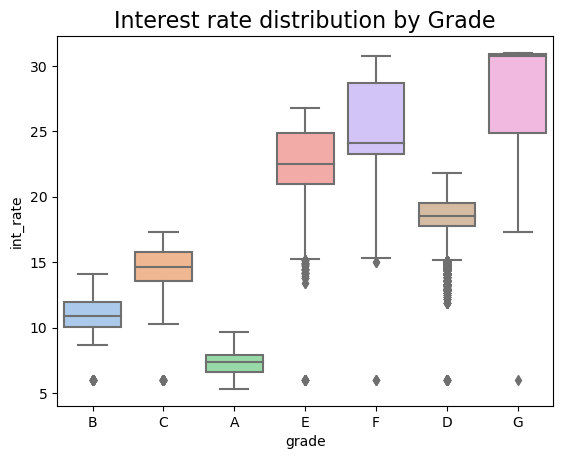

In [64]:
# Interest vs sub-grade

# plot the distribution of interest rate in each loan grade
sns.boxplot(x='grade', y='int_rate', data=loan_data, palette="pastel")
plt.title("Interest rate distribution by Grade", fontsize=16)

In [65]:
# remove the columns that do not involve in the model
loan_data.drop(columns=['loan_amnt_range', 'int_rate_range', 'annual_inc_range'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [66]:
# Pearson correlation matrix
# Create Pearson correlation with absolute values
corr_table = loan_data.corr().abs()

In [67]:
# drop_duplicates() may drop all correlation with a variables itself except the fisrt duplicate (loan_amount), we will check the heat map later
# filter out the pair of features which have a correlation value larger than 0.7
corr_table[corr_table>0.7].unstack().transpose().sort_values(ascending=False).drop_duplicates()

loan_amnt        loan_amnt          1.000000
num_sats         open_acc           0.999220
loan_amnt        funded_amnt        0.998858
total_pymnt      total_pymnt_inv    0.998145
funded_amnt_inv  funded_amnt        0.997658
                                      ...   
total_rec_int    total_pymnt_inv    0.715366
loan condition   hardship_length    0.705320
total_acc        num_sats           0.701019
open_acc         total_acc          0.700385
loan_amnt        int_rate                NaN
Length: 70, dtype: float64

In [68]:
# Data prepration
# Cleaning columns
# Based on the exploratory data analysis part, there are columns should be removed with below reasons.

# Reason 1: Unrelated information
# Columns have less usefull information related to the purpose of this project

loan_data.filter(items=['zip_code','title','emp_title','inq_fi','mths_since_recent_inq', 'inq_last_6mths']).head()

,title,emp_title,inq_fi,mths_since_recent_inq,inq_last_6mths
0,Computer,NaN,NaN,NaN,1.0
1,bike,Ryder,NaN,NaN,5.0
2,real estate business,NaN,NaN,NaN,2.0
3,personel,AIR RESOURCES BOARD,NaN,NaN,1.0
4,Personal,University Medical Group,NaN,NaN,0.0


In [69]:
# Drop above columns
loan_data.drop(columns=['title','emp_title','inq_fi','mths_since_recent_inq', 'inq_last_6mths'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [70]:
# Reason 2: Missing values
# Columns have too many missing values
# check and calculate the percentage of null values out of the total values counted in each column
null_values = loan_data.isnull().sum()
# len(df.index) is to count the total number of values in a columns supposed to have
percent_nullvalues = null_values/len(loan_data.index)*100 

In [71]:
# sort the percentage of missing values from high to low
percent_nullvalues.sort_values(ascending=False, axis=0)

next_pymnt_d            100.000000
hardship_loan_status     99.503403
hardship_end_date        99.502985
hardship_reason          99.502985
hardship_status          99.502985
                           ...    
total_pymnt               0.000000
out_prncp_inv             0.000000
out_prncp                 0.000000
initial_list_status       0.000000
fico_rating               0.000000
Length: 134, dtype: float64

In [72]:
# remove columns with a condition that more than 50% of the values in that column is null
loan_data.dropna(axis=1, thresh=(1-0.50)*len(loan_data.index), inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [73]:
# date and time
loan_data_date = loan_data.filter(items=['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d'])
loan_data_date.head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,Dec-2011,Jan-1985,Jan-2015,May-2020
1,Dec-2011,Apr-1999,Apr-2013,Oct-2016
2,Dec-2011,Nov-2001,Jun-2014,Jun-2017
3,Dec-2011,Feb-1996,Jan-2015,Apr-2016
4,Dec-2011,Jan-1996,Jan-2017,Apr-2018


In [74]:
loan_data.drop(columns=['initial_list_status', 'grade', 
                 'chargeoff_within_12_mths', 'tax_liens', 'policy_code', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
                 'num_tl_90g_dpd_24m', 'pymnt_plan', 'acc_now_delinq', 'debt_settlement_flag', 'delinq_amnt', 
                 'issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d',
                ], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [75]:
# Reason 4: Collected data after a loan is granted
# There are also columns presenting what happens after a loan is granted. 
# They should be dropped to avoid the overfitting model. 
# They are the information related to recoveries, installments, or hardship. 
# For example, hardship_flag should be removed because it is applied as a last resort for a borrower when he/she is struggling to pay monthly installments after getting the loan.

loan_data.drop(columns=['funded_amnt', 'funded_amnt_inv', 'out_prncp', 'out_prncp_inv', 'last_fico_range_low',
                 'last_fico_range_high','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee','tot_coll_amt','last_pymnt_amnt',
                 'total_il_high_credit_limit', 'hardship_flag', 'installment', 
                 'revol_util','collections_12_mths_ex_med'],
                inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [76]:
# Reason 5: High correlation - Based on Pearson correlation matrix

# After droping some columns, we create a new correlation table for the rest of features
cr = loan_data.corr().abs()

# filter out the pair of features with correlation score larger than 0.7
cr[corr_table>0.7].unstack().transpose().sort_values(ascending=False).drop_duplicates()

loan_amnt             loan_amnt               1.000000
open_acc              num_sats                0.999220
num_rev_tl_bal_gt_0   num_actv_rev_tl         0.986036
tot_cur_bal           tot_hi_cred_lim         0.975163
total_bal_ex_mort     total_bal_il            0.912629
total_bc_limit        bc_open_to_buy          0.859256
bc_util               percent_bc_gt_75        0.851047
open_rv_24m           acc_open_past_24mths    0.846627
num_bc_tl             num_rev_accts           0.843574
num_op_rev_tl         open_acc                0.841357
num_sats              num_op_rev_tl           0.840903
open_rv_12m           num_tl_op_past_12m      0.839199
avg_cur_bal           tot_cur_bal             0.829550
num_actv_rev_tl       num_actv_bc_tl          0.825252
num_actv_bc_tl        num_bc_sats             0.824284
                      num_rev_tl_bal_gt_0     0.819081
avg_cur_bal           tot_hi_cred_lim         0.788038
num_op_rev_tl         num_rev_accts           0.781095
num_rev_tl

In [77]:
# drop features based on the results above
loan_data.drop(columns=['num_sats','num_rev_tl_bal_gt_0', 'tot_hi_cred_lim',
                'bc_open_to_buy', 'percent_bc_gt_75', 'total_bal_ex_mort',
                'num_rev_accts', 'num_actv_bc_tl', 'num_op_rev_tl', 
                'avg_cur_bal', 'num_tl_op_past_12m', 'open_rv_24m', 'open_il_24m',
                'pub_rec_bankruptcies', 'total_rev_hi_lim', 'num_bc_sats',
                'total_acc'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [78]:
loan_data.drop(columns=['loan condition'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [79]:
loan_data.drop(columns=['fico_rating'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [80]:
# check again if any correlation coefficients >0.7
cr = loan_data.corr().abs()
cr[corr_table>0.7].unstack().transpose().sort_values(ascending=False).drop_duplicates()

loan_amnt  loan_amnt    1.0
           int_rate     NaN
dtype: float64

<AxesSubplot:>

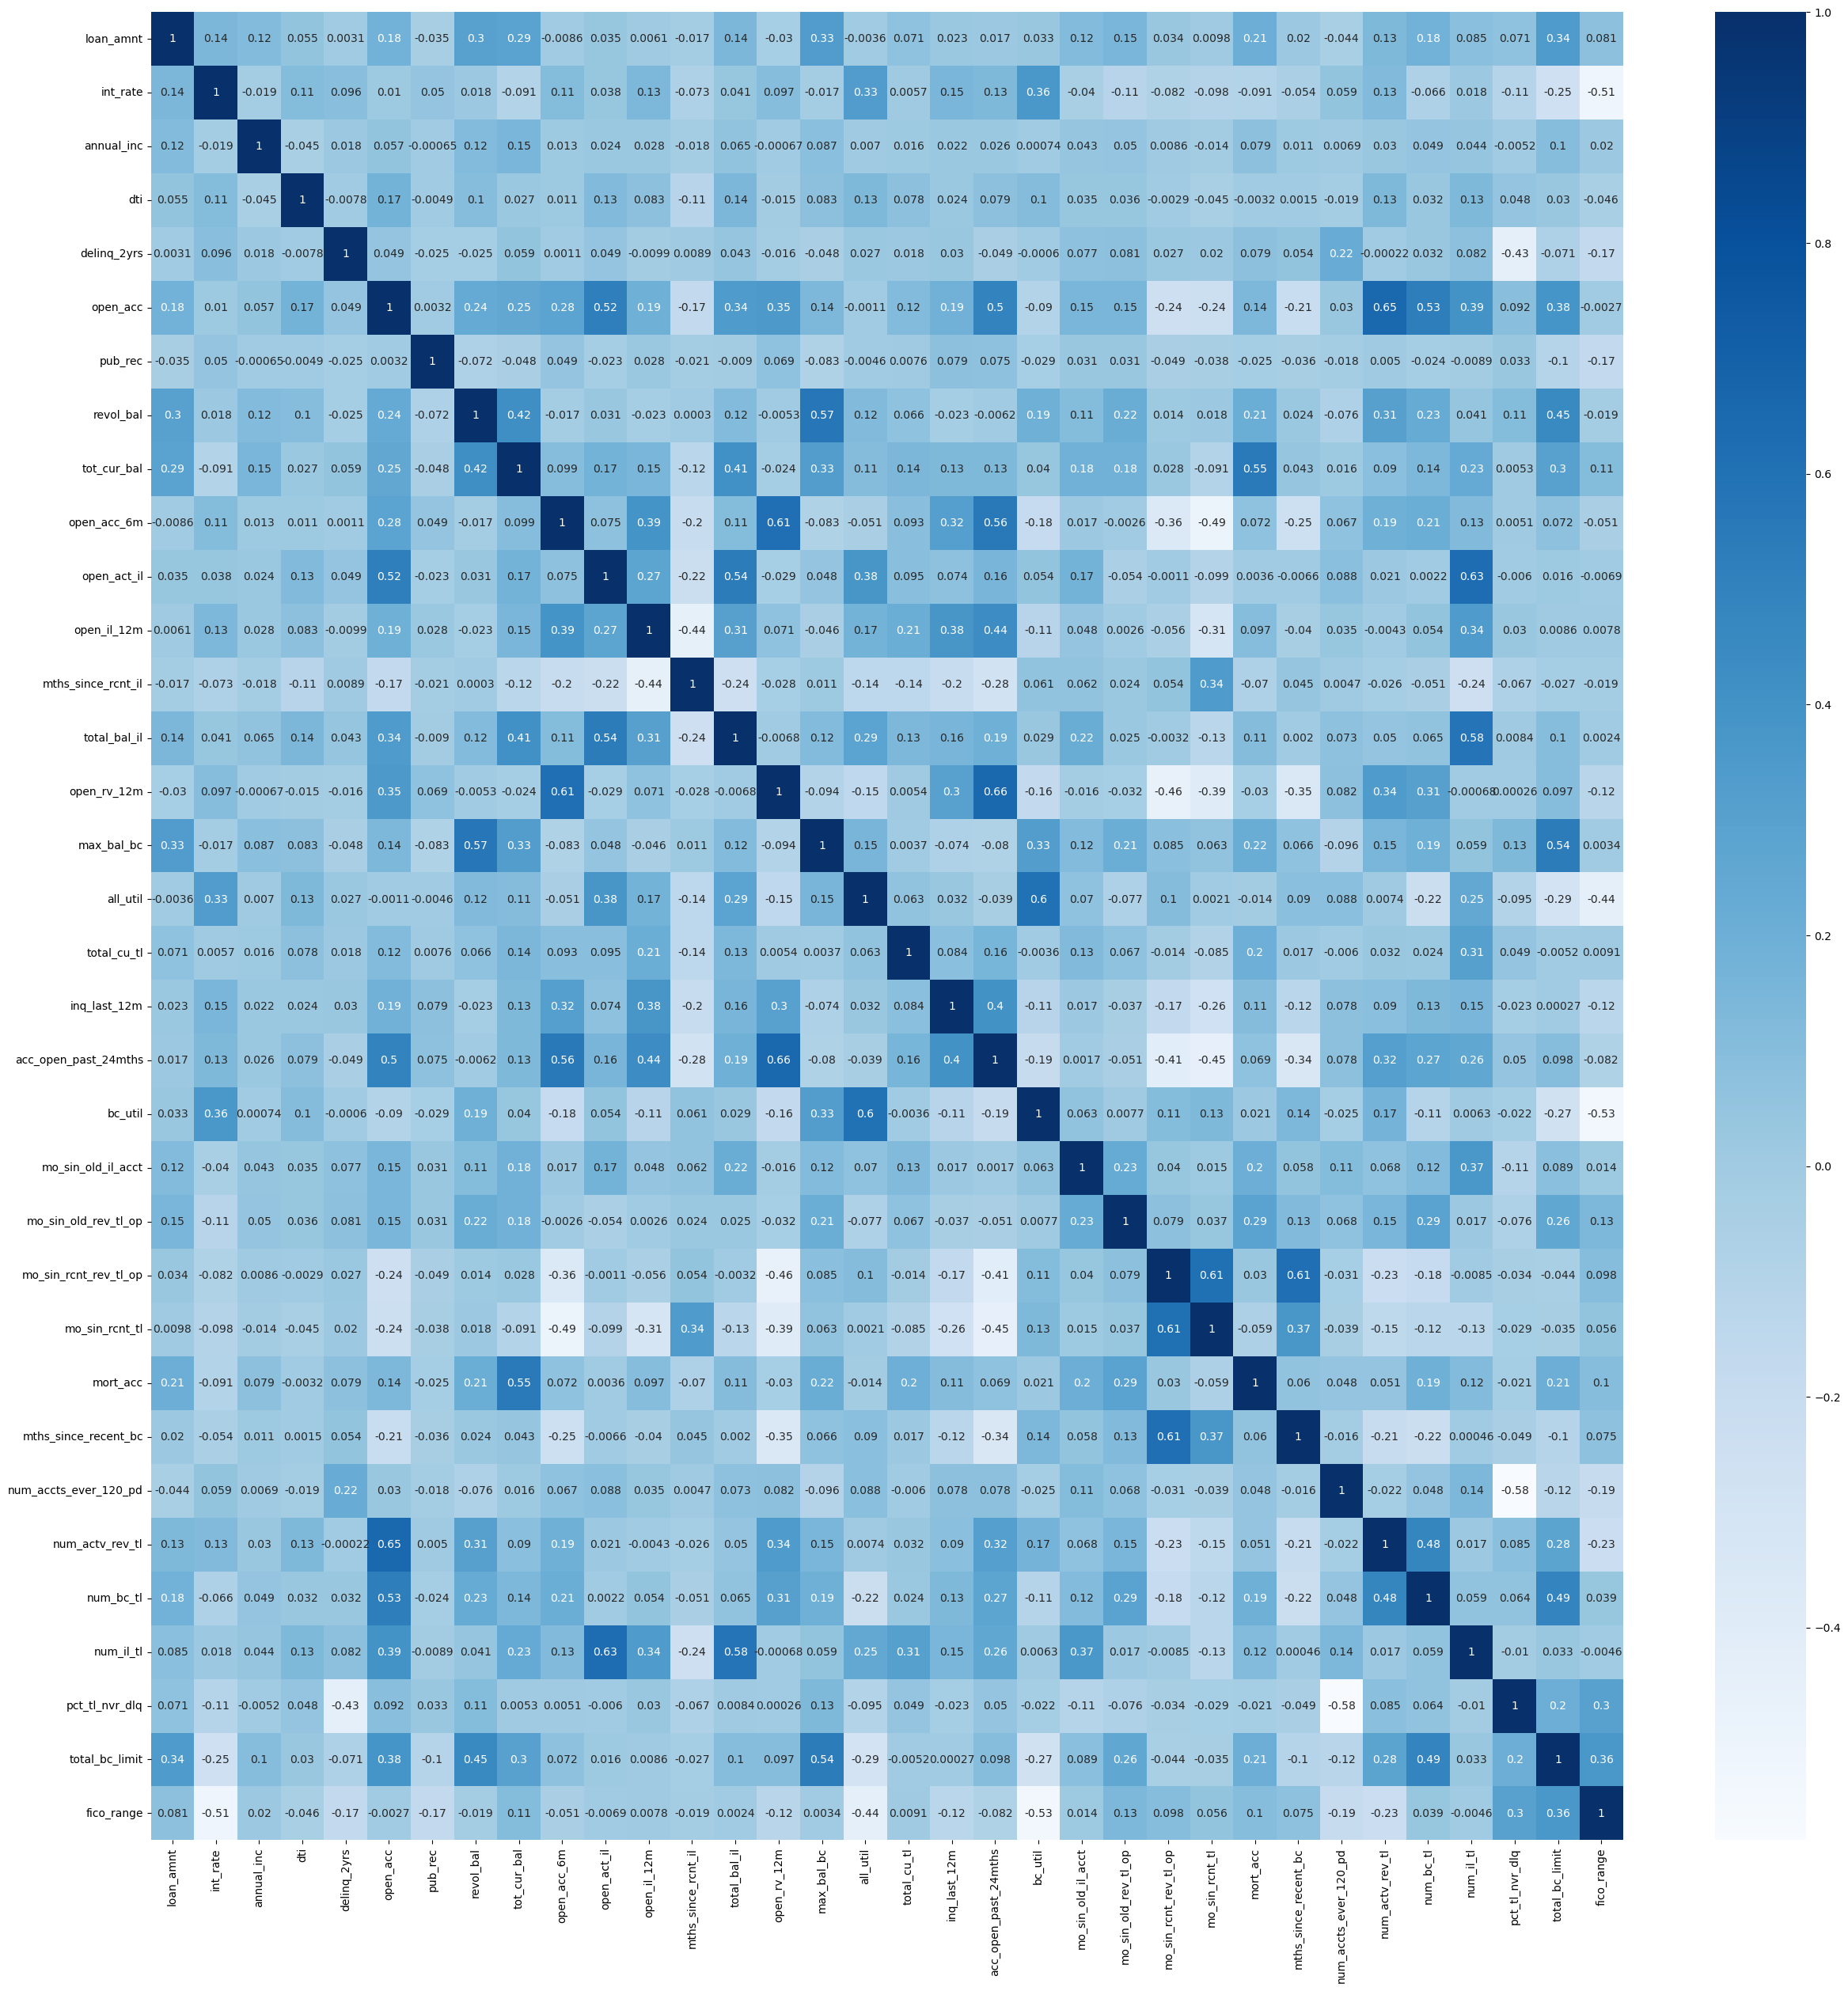

In [81]:
# final check with correlation matrix
plt.figure(figsize=(30,30))        
sns.heatmap(loan_data.corr(), annot=True, cmap="Blues")

In [82]:
# Cleaning rows

# check duplicated values
loan_data.duplicated(keep='first')

0         False
1         False
2         False
3         False
4         False
          ...  
699988    False
699991    False
699992    False
699993    False
699997    False
Length: 478658, dtype: bool

In [83]:
# if the sum value is not 0, meanning there is a duplicated row
loan_data.duplicated(keep='first').sum()

0

In [84]:
# Conclusion: There is no rows which are exactly duplicated.

# drop rows with missing values
loan_data.dropna(inplace=True)

# check missing value in rows
loan_data.isnull().sum().sort_values()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


loan_amnt                0
open_rv_12m              0
max_bal_bc               0
all_util                 0
total_cu_tl              0
inq_last_12m             0
acc_open_past_24mths     0
bc_util                  0
mo_sin_old_il_acct       0
total_bal_il             0
mo_sin_old_rev_tl_op     0
mo_sin_rcnt_tl           0
mort_acc                 0
mths_since_recent_bc     0
num_accts_ever_120_pd    0
num_actv_rev_tl          0
num_bc_tl                0
num_il_tl                0
pct_tl_nvr_dlq           0
mo_sin_rcnt_rev_tl_op    0
total_bc_limit           0
mths_since_rcnt_il       0
open_act_il              0
term                     0
int_rate                 0
sub_grade                0
emp_length               0
home_ownership           0
annual_inc               0
verification_status      0
loan_status              0
open_il_12m              0
purpose                  0
dti                      0
delinq_2yrs              0
open_acc                 0
pub_rec                  0
r

In [85]:
# check the final dimension of the dataset after cleaning
loan_data.shape

(220726, 43)

In [86]:
# Convert data types
# XGBoost model only allows for int, float, or boolean data types, so we check and convert where necessary.

# check the data type for each feature
loan_data.dtypes.sort_values()

loan_amnt                float64
open_rv_12m              float64
max_bal_bc               float64
all_util                 float64
total_cu_tl              float64
inq_last_12m             float64
acc_open_past_24mths     float64
bc_util                  float64
mo_sin_old_il_acct       float64
total_bal_il             float64
mo_sin_old_rev_tl_op     float64
mo_sin_rcnt_tl           float64
mort_acc                 float64
mths_since_recent_bc     float64
num_accts_ever_120_pd    float64
num_actv_rev_tl          float64
num_bc_tl                float64
num_il_tl                float64
pct_tl_nvr_dlq           float64
mo_sin_rcnt_rev_tl_op    float64
total_bc_limit           float64
mths_since_rcnt_il       float64
open_act_il              float64
int_rate                 float64
annual_inc               float64
open_il_12m              float64
dti                      float64
delinq_2yrs              float64
fico_range               float64
pub_rec                  float64
revol_bal 

In [130]:
# Remove the non-numeric characters from the "term" column
loan_data['term'] = loan_data['term'].str.extract('(\d+)').astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [132]:
# Map the "sub_grade" column to a numerical value
sub_grade_mapping = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
                     'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
                     'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
                     'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
                     'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
                     'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30,
                     'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35}
loan_data['sub_grade'] = loan_data['sub_grade'].map(sub_grade_mapping)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [134]:
# Map the "emp_length" column to a numerical value
emp_length_mapping = {'< 1 year': 0.5, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, 
                      '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, 
                      '10+ years': 10}
loan_data['emp_length'] = loan_data['emp_length'].map(emp_length_mapping)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [136]:
# Map the "home_ownership" column to a numerical value
home_ownership_mapping = {'MORTGAGE': 1, 'RENT': 2, 'OWN': 3, 'OTHER': 4, 'NONE': 5, 'ANY': 6}
loan_data['home_ownership'] =loan_data['home_ownership'].map(home_ownership_mapping)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [138]:
# Map the "verification_status" column to a numerical value
verification_status_mapping = {'Not Verified': 0, 'Source Verified': 1, 'Verified': 2}
loan_data['verification_status'] = loan_data['verification_status'].map(verification_status_mapping)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [140]:
# Map the "purpose" column to a numerical value
purpose_mapping = {'debt_consolidation': 1, 'credit_card': 2, 'home_improvement': 3, 'other': 4, 'major_purchase': 5,
                   'small_business': 6, 'car': 7, 'medical': 8, 'moving': 9, 'vacation': 10, 'house': 11, 'wedding': 12,
                   'renewable_energy': 13, 'educational': 14}
loan_data['purpose'] = loan_data['purpose'].map(purpose_mapping)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [144]:
# One-hot encode the state column
addr_state_dummies = pd.get_dummies(loan_data['addr_state'], prefix='addr_state')

# Concatenate the one-hot encoded columns with the original dataframe
loan_data = pd.concat([loan_data, addr_state_dummies], axis=1)

In [147]:
# Drop the original 'state' column
loan_data = loan_data.drop('addr_state', axis=1)

In [150]:
# Perform one-hot encoding on the 'application_type' column
application_type_dummies = pd.get_dummies(loan_data['application_type'], prefix='application_type')

# Concatenate the one-hot encoded columns with the original dataframe
loan_data = pd.concat([loan_data, application_type_dummies], axis=1)

# Drop the original 'application_type' column
loan_data = loan_data.drop('application_type', axis=1)

In [152]:
# Define the target variable and the features
target = 'loan_status'
features = loan_data.columns.drop(target)

# Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(loan_data[features])

# Perform outlier detection with Isolation Forest
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=42)
clf.fit(df_scaled)

# Identify the outliers
outliers = clf.predict(df_scaled)
loan_data_outliers = loan_data[outliers == -1]

# Print the number of outliers and their loan statuses
print('Number of outliers:', len(loan_data_outliers))
print('Outlier loan statuses:\n', loan_data_outliers[target].value_counts())

Number of outliers: 11037
Outlier loan statuses:
 Fully Paid     8251
Charged Off    2786
Name: loan_status, dtype: int64


In [157]:
# Compute summary statistics
means = loan_data.mean(axis=0)
stds = loan_data.std(axis=0)

# Calculate the Z-score
z_scores = np.abs((loan_data - means) / stds)

# Identify outliers
threshold = 3
outliers = (z_scores > threshold).any(axis=1)

# Print the number of outliers
print(f'Number of outliers: {outliers.sum()}')

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Number of outliers: 200171


In [159]:
from sklearn.feature_selection import SelectKBest, f_classif

# Define the features and target
X = loan_data.drop(['loan_status'], axis=1)
y = loan_data['loan_status']

# Perform feature selection using ANOVA F-value between label/feature for classification tasks
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)

# Get the columns to keep
cols = selector.get_support(indices=True)

# Get the columns to drop
cols_to_drop = X.columns[~X.columns.isin(X.columns[cols])]

# Create a new dataframe with the selected features
X_new = X.iloc[:,cols]

# Print the selected features
print(X_new.columns)

Index(['loan_amnt', 'term', 'int_rate', 'sub_grade', 'verification_status',
       'all_util', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'fico_range'],
      dtype='object')


In [160]:
# Calculate the ANOVA F-value between each feature and the target
f_values, p_values = f_classif(X, y)

# Print the ANOVA F-value for each feature
for i, col in enumerate(X.columns):
    print(f"{col}: {f_values[i]}")

loan_amnt: 2640.218017726199
term: 6599.372206574225
int_rate: 17149.518764093707
sub_grade: 17675.167814280732
emp_length: 146.69665802174586
home_ownership: 762.8383846094068
annual_inc: 9.360046847360021
verification_status: 2655.359309044273
purpose: 0.3728663128919261
dti: 579.3534312638453
delinq_2yrs: 123.9019774075103
open_acc: 31.84436229114096
pub_rec: 134.4465002047882
revol_bal: 36.84883970786087
tot_cur_bal: 1284.453211232164
open_acc_6m: 694.2815267233785
open_act_il: 14.613888537797541
open_il_12m: 95.1635576248376
mths_since_rcnt_il: 2.9938573222345397
total_bal_il: 5.846888633402932
open_rv_12m: 1084.8985329512877
max_bal_bc: 214.02906398091213
all_util: 1296.6850330408158
total_cu_tl: 113.4170807902415
inq_last_12m: 868.7510106429456
acc_open_past_24mths: 1017.3470370701777
bc_util: 1418.2535107039885
mo_sin_old_il_acct: 343.1464296162605
mo_sin_old_rev_tl_op: 839.701623577361
mo_sin_rcnt_rev_tl_op: 555.9322460371826
mo_sin_rcnt_tl: 379.43254408217126
mort_acc: 2008.4

In [87]:
# Setting dummies


# One-hot encoding with Pandas: setting the dummies
loan_data_xgb = pd.get_dummies(loan_data, columns=['application_type',
                                    'addr_state',
                                    'purpose',
                                    'verification_status',
                                    'home_ownership',
                                    'emp_length',
                                    'sub_grade',
                                    'term'])
# reset index
loan_data_xgb= loan_data_xgb.reset_index()
# check the new data created
loan_data_xgb.head().transpose()

,0,1,2,3,4
index,230717,230723,230725,230729,230730
loan_amnt,12000.0,10000.0,12800.0,15000.0,40000.0
int_rate,7.97,9.44,13.59,13.59,7.97
annual_inc,42000.0,55000.0,90000.0,180000.0,200000.0
loan_status,Fully Paid,Fully Paid,Fully Paid,Fully Paid,Charged Off
...,...,...,...,...,...
sub_grade_G3,0,0,0,0,0
sub_grade_G4,0,0,0,0,0
sub_grade_G5,0,0,0,0,0
term_ 36 months,1,1,1,1,0


In [88]:
# Convert classes in loan_status to positive class (1) and negative class (0)
loan_data_xgb = loan_data_xgb.replace({"loan_status":{ "Fully Paid": 0, "Charged Off": 1}})

In [89]:
# to avoid error while training model, replacing all space or special characters in column names into '_' 
loan_data_xgb.rename(columns={'emp_length_10+ years':'emp_length_10_more_years',
                       'emp_length_< 1 year':'emp_length_less_1_year'}, errors="raise", inplace=True)

for text in loan_data_xgb.columns:
    new_name = text.replace(' ','_')
    loan_data_xgb.rename(columns={text:new_name},inplace=True)

In [90]:
# Set up independant and dependant variables
# The main purpose here is predict status of borrowers. We denote:

# x as predictors
# y as the response variable of the model
# Obviously, x contains all features in the dataset except loan_status.

# Split data for x
x = loan_data_xgb.drop(columns=['loan_status'], axis=1).copy()
x.head().T

,0,1,2,3,4
index,230717.00,230723.00,230725.00,230729.00,230730.00
loan_amnt,12000.00,10000.00,12800.00,15000.00,40000.00
int_rate,7.97,9.44,13.59,13.59,7.97
annual_inc,42000.00,55000.00,90000.00,180000.00,200000.00
dti,27.74,18.79,22.63,38.07,14.37
...,...,...,...,...,...
sub_grade_G3,0.00,0.00,0.00,0.00,0.00
sub_grade_G4,0.00,0.00,0.00,0.00,0.00
sub_grade_G5,0.00,0.00,0.00,0.00,0.00
term__36_months,1.00,1.00,1.00,1.00,0.00


In [91]:
x.shape

(220726, 156)

In [92]:
# assign data for y
y = loan_data_xgb['loan_status']

#Convert y to integer type for further calculation
y = y.astype('int')
y.head()


0    0
1    0
2    0
3    0
4    1
Name: loan_status, dtype: int64

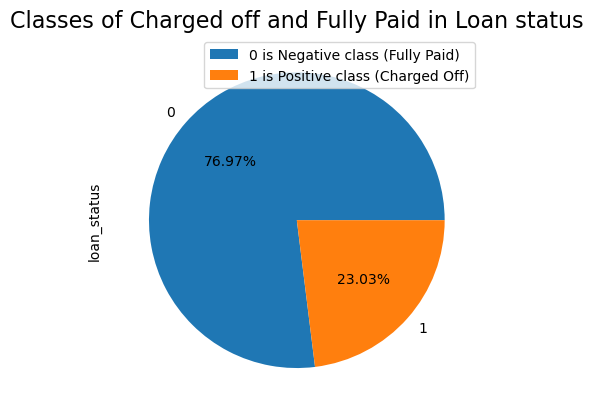

In [93]:
# Data split
## Observe the imbalance data
loan_data_xgb.loan_status.value_counts().plot.pie(autopct='%.2f%%')
plt.title('Classes of Charged off and Fully Paid in Loan status', fontsize=16)
plt.legend(labels=['0 is Negative class (Fully Paid)', '1 is Positive class (Charged Off)']) 

In [94]:
# shuffling data and split it in a stratified fashion  
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, train_size=0.7, random_state=42, stratify=y)

In [95]:
# check if the stratified sampling method works by calculating the percentage of the Charged Off class
print('Percentage of Charged Off label in y_train: ', round(sum(y_train)/len(y_train)*100, 2), '%')

Percentage of Charged Off label in y_train:  23.03 %


In [96]:
# Size of data samples
print('Independent training size (x_train):', x_train.shape)
print('Dependent training size (y_train):', y_train.shape)
print('Independent testing size (x_test):', x_test.shape)
print('Dependent testing size (y_train):', y_test.shape)

Independent training size (x_train): (154508, 156)
Dependent training size (y_train): (154508,)
Independent testing size (x_test): (66218, 156)
Dependent testing size (y_train): (66218,)


In [97]:
# XGBOOST MODEL DEVELOPMENT
# For imbalanced data, we set a base line score with Random Rate guessing strategy. There is no backed up theory for this, I use it as a rule of thumb.

# Odds of Guessing Minority Correct + Odds of Guessing Majority Correct = Baseline score 
# =0.23(sqaured)+0.77(sqaured)=0.645

# We will try to train a model with important scores above 64.5%.

# Source: 'Choosing a Baseline Accuracy for a Classification Model'.Towards Data Science. Aaron Lee. https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f

In [98]:
# Initial model
# Initial XGBoost model
%time
# XGBoost model with default setting
xgb_1st = xgb.XGBClassifier(objective='binary:logistic', # the loss function used
                            use_label_encoder=False, # to remove a warning about future release
                            random_state=42) # without fixed number of random_state, each time running model will generate a different result 

xgb_1st.fit(x_train, y_train, 
              verbose=1, # show messages while training 
              early_stopping_rounds=20, 
              eval_metric='aucpr',  
              eval_set=[(x_train, y_train), (x_test, y_test)])

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 9.06 µs


`use_label_encoder` is deprecated in 1.7.0.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-aucpr:0.40647	validation_1-aucpr:0.39915
[1]	validation_0-aucpr:0.41877	validation_1-aucpr:0.41224
[2]	validation_0-aucpr:0.42452	validation_1-aucpr:0.41747
[3]	validation_0-aucpr:0.43026	validation_1-aucpr:0.42077
[4]	validation_0-aucpr:0.43334	validation_1-aucpr:0.42316
[5]	validation_0-aucpr:0.43697	validation_1-aucpr:0.42577
[6]	validation_0-aucpr:0.44050	validation_1-aucpr:0.42664
[7]	validation_0-aucpr:0.44277	validation_1-aucpr:0.42744
[8]	validation_0-aucpr:0.44618	validation_1-aucpr:0.42893
[9]	validation_0-aucpr:0.45050	validation_1-aucpr:0.43064
[10]	validation_0-aucpr:0.45418	validation_1-aucpr:0.43212
[11]	validation_0-aucpr:0.45670	validation_1-aucpr:0.43304
[12]	validation_0-aucpr:0.46009	validation_1-aucpr:0.43441
[13]	validation_0-aucpr:0.46399	validation_1-aucpr:0.43505
[14]	validation_0-aucpr:0.46597	validation_1-aucpr:0.43589
[15]	validation_0-aucpr:0.46952	validation_1-aucpr:0.43678
[16]	validation_0-aucpr:0.47198	validation_1-aucpr:0.43705
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [99]:
# write a function helping to generate evaluation scores and confusion matrices at the same time
def evaluate_model(model_name, data_x, data_y):
    
    # prediction on training/test set
    y_prediction = model_name.predict(data_x)
    print('\n') # insert a break line
    
    # print out the report of precision, recall, accuracy and f1 scores
    print('1) CLASSIFICATION REPORT:') 
    print(classification_report(data_y, y_prediction))
    print('\n')
    
    # print out confusion matrix coresponding to the data set
    print('2) CONFUSION MATRIX')
    plot_confusion_matrix(model_name, data_x, data_y, display_labels=(['Fully Paid','Charged Off']))



1) CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88    118920
           1       0.68      0.20      0.30     35588

    accuracy                           0.79    154508
   macro avg       0.74      0.58      0.59    154508
weighted avg       0.77      0.79      0.75    154508



2) CONFUSION MATRIX


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


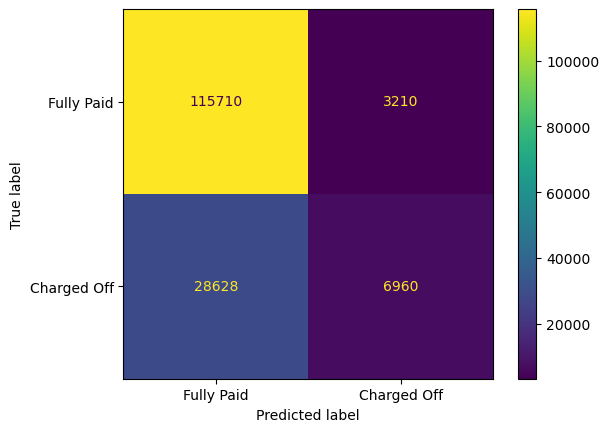

In [100]:
# Evaluation on the training set
evaluate_model(xgb_1st, x_train, y_train)




1) CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87     50966
           1       0.57      0.15      0.24     15252

    accuracy                           0.78     66218
   macro avg       0.68      0.56      0.56     66218
weighted avg       0.74      0.78      0.73     66218



2) CONFUSION MATRIX


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


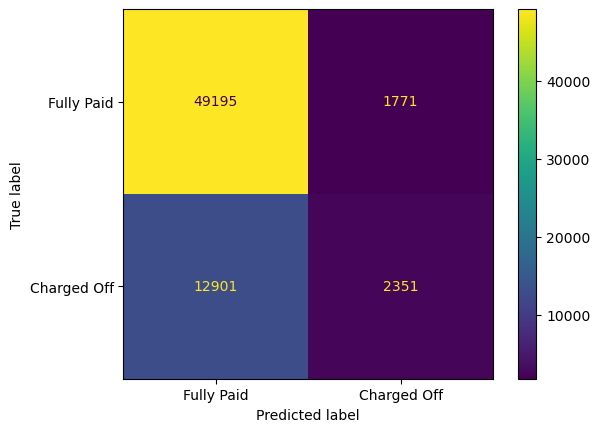

In [101]:
# Evaluation on the test set
evaluate_model(xgb_1st, x_test, y_test)

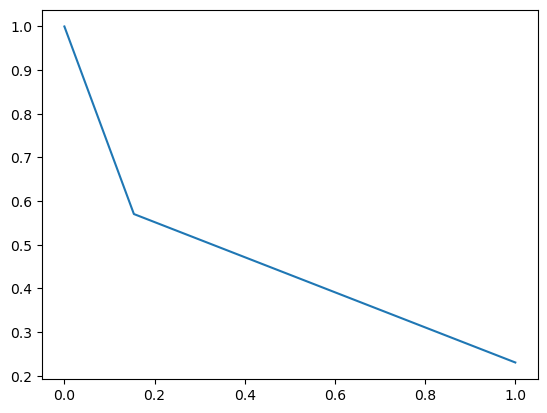

In [102]:
# Precision-Recall Curve
y_pred_1st = xgb_1st.predict(x_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred_1st)
plt.plot(recall, precision)

In [103]:
# define a learning curves function
def learn_curves(fitted_model):
    
    # retrieve performance metrics
    results = fitted_model.evals_result()

    # plot learning curves
    plt.plot(results['validation_0']['aucpr'], label='Learning curve on training set')
    plt.plot(results['validation_1']['aucpr'], label='Learning curve on test set')

    # show the legends and plot
    plt.legend()

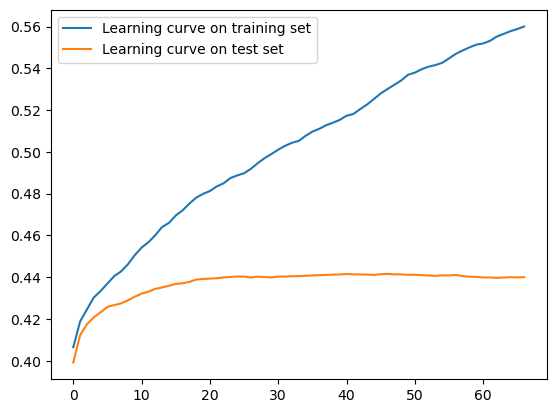

In [104]:
# Learning curve of the initial model
learn_curves(xgb_1st)

In [105]:
# Tuning hyperparameters

# Step 1: Create parameter spaces
params = {'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
         'n_estimators': [100, 200, 400, 800, 1000],
         'scale_pos_weight': [1, 2, 3, 4],
         'max_depth': [3,4, 5,6, 7,8, 9,10],
         'gamma': [0, 0.01, 0.1, 0.5, 1, 2],
         'min_child_weight': [1, 2, 3, 4, 5,6,7,8,9,10],
         'colsample_bytree': [0.8, 0.9, 1],
         }

In [106]:
# Choose a method: Stratified K-Fold Cross Validation
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [107]:
# Decide the score metrics to evaluate your model: based on recall score

In [108]:
# Approach 1
# RandomizedSearchCV is executed with different evaluation scores: recall, accuracy and roc_auc.

# %time
# Run RandomizedSearchCV to tune the hyperparameter 
# random = RandomizedSearchCV(xgb_1st, 
#                            param_distributions=params, 
#                            cv=kfold, 
#                            n_iter=5, 
#                            scoring='recall',
#                            n_jobs=-1)

#random.fit(x_train, y_train)

#print('Best hyperparameter:', random.best_params_)
#print('Best score:', random.best_score_)

In [109]:
# Optimized model
# early_stopping_rounds=10: reduce it to prevent overfitting based on the learning curves of initial model
# The model below presented below is just one of the candidates we can consider for the final model chosen for the Dash app. All hyperparameter combinations found should be fitted and evaluated with the same steps.
# Fit the model
%time
# run the model with added hyperparameters
xgb_model_op = xgb.XGBClassifier(objective='binary:logistic',
                                  learning_rate=0.01, 
                                 scale_pos_weight=4,
                                 n_estimators=800,
                                 max_depth=5,
                                 min_child_weight=1,
                                 gamma=2, 
                                 colsample_bytree=1,
                                 use_label_encoder=False,
                                 random_state=42)

xgb_model_op.fit(x_train, y_train, 
                 verbose=1, 
                 early_stopping_rounds=10, 
                 eval_metric='aucpr', 
                 eval_set=[(x_train, y_train), (x_test, y_test)])

CPU times: user 19 µs, sys: 1 µs, total: 20 µs
Wall time: 4.29 µs


`use_label_encoder` is deprecated in 1.7.0.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-aucpr:0.39490	validation_1-aucpr:0.39319
[1]	validation_0-aucpr:0.39633	validation_1-aucpr:0.39429
[2]	validation_0-aucpr:0.39682	validation_1-aucpr:0.39489
[3]	validation_0-aucpr:0.39844	validation_1-aucpr:0.39640
[4]	validation_0-aucpr:0.39843	validation_1-aucpr:0.39708
[5]	validation_0-aucpr:0.40162	validation_1-aucpr:0.40017
[6]	validation_0-aucpr:0.40206	validation_1-aucpr:0.40038
[7]	validation_0-aucpr:0.40278	validation_1-aucpr:0.40104
[8]	validation_0-aucpr:0.40296	validation_1-aucpr:0.40105
[9]	validation_0-aucpr:0.40345	validation_1-aucpr:0.40146
[10]	validation_0-aucpr:0.40319	validation_1-aucpr:0.40158
[11]	validation_0-aucpr:0.40331	validation_1-aucpr:0.40165
[12]	validation_0-aucpr:0.40323	validation_1-aucpr:0.40136
[13]	validation_0-aucpr:0.40335	validation_1-aucpr:0.40154
[14]	validation_0-aucpr:0.40340	validation_1-aucpr:0.40150
[15]	validation_0-aucpr:0.40383	validation_1-aucpr:0.40220
[16]	validation_0-aucpr:0.40391	validation_1-aucpr:0.40224
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [110]:
# Logistic model
%time
logis_model = LogisticRegression(solver='liblinear',
                                 max_iter=100,
                                 multi_class='ovr', # for binary classification problem
                                 class_weight = {0:0.2, 1:0.8}, # assigned weights for positie and negative class
                                 verbose=1,
                                random_state=42)

logis_model.fit(x_train, y_train)

CPU times: user 19 µs, sys: 4 µs, total: 23 µs
Wall time: 11 µs
[LibLinear]iter  1 act 4.221e+02 pre 4.183e+02 delta 1.345e-06 f 3.622e+04 |g| 1.099e+09 CG   3
cg reaches trust region boundary
iter  2 act 4.807e+01 pre 4.664e+01 delta 1.395e-06 f 3.580e+04 |g| 6.899e+07 CG   1
cg reaches trust region boundary
iter  3 act 6.836e+01 pre 9.050e+01 delta 1.395e-06 f 3.575e+04 |g| 4.642e+08 CG   3
cg reaches trust region boundary
iter  4 act 3.798e+01 pre 1.164e+02 delta 8.679e-07 f 3.568e+04 |g| 1.517e+08 CG   3
cg reaches trust region boundary
iter  5 act 5.146e+01 pre 5.142e+01 delta 1.105e-06 f 3.564e+04 |g| 1.105e+08 CG   3
cg reaches trust region boundary
iter  6 act 4.117e+01 pre 5.471e+01 delta 1.140e-06 f 3.559e+04 |g| 8.107e+07 CG   3
cg reaches trust region boundary
iter  7 act 8.937e+00 pre 6.920e+01 delta 5.699e-07 f 3.555e+04 |g| 1.119e+08 CG   2
cg reaches trust region boundary
iter  8 act 2.900e+01 pre 2.928e+01 delta 6.303e-07 f 3.554e+04 |g| 1.037e+08 CG   2
cg reaches tru

LogisticRegression(class_weight={0: 0.2, 1: 0.8}, multi_class='ovr',
                   random_state=42, solver='liblinear', verbose=1)



1) CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.88      0.58      0.70     50966
           1       0.34      0.73      0.46     15252

    accuracy                           0.61     66218
   macro avg       0.61      0.65      0.58     66218
weighted avg       0.75      0.61      0.64     66218



2) CONFUSION MATRIX


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


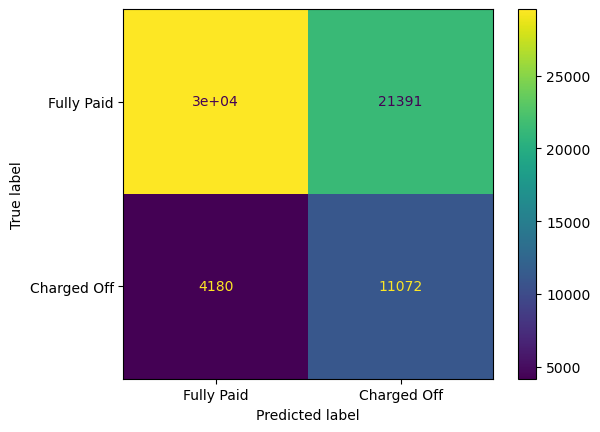

In [111]:
# Evaluation
evaluate_model(logis_model, x_test, y_test)

In [112]:
# ROC and precision-recall curves
y_pred_prob_lgt = logis_model.predict_proba(x_test)[:,1]
roc_auc_score(y_test, y_pred_prob_lgt)

0.7121982719508198

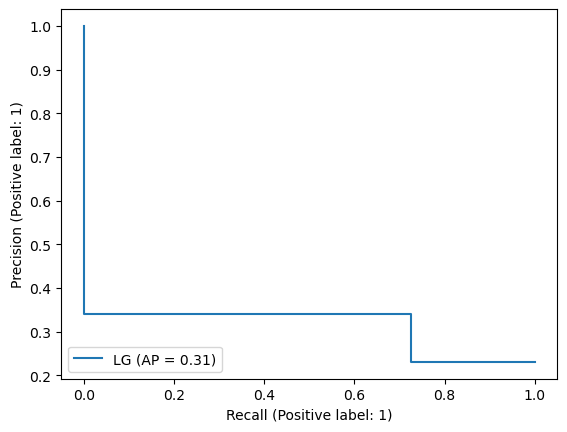

In [113]:
# Precision-Recall curve
y_pred_lgt = logis_model.predict(x_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred_lgt, name="LG")

In [114]:
from sklearn.ensemble import RandomForestClassifier

In [115]:
# Import the necessary modules
from sklearn.metrics import accuracy_score

# Create a Random Forest classifier with default hyperparameters
rfc = RandomForestClassifier(random_state=42)

# Train the model on the training set
rfc.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = rfc.predict(x_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')


Accuracy: 0.776


In [116]:
# Import the necessary modules
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87     50966
           1       0.60      0.09      0.15     15252

    accuracy                           0.78     66218
   macro avg       0.69      0.54      0.51     66218
weighted avg       0.74      0.78      0.71     66218



In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

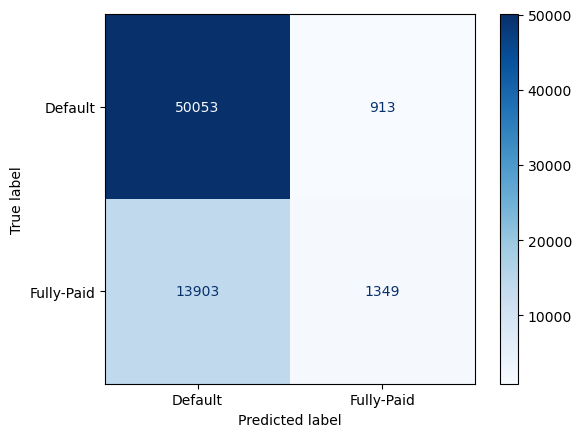

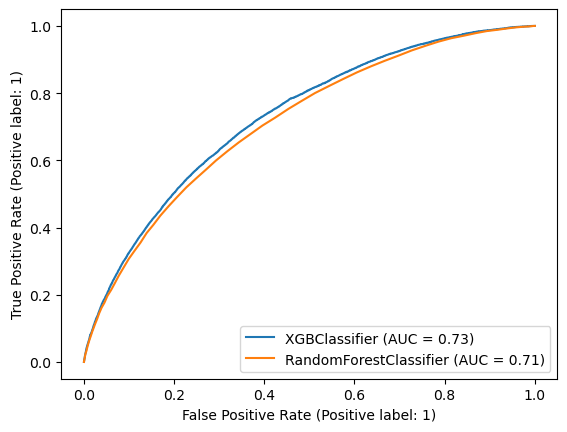

In [120]:
disp = ConfusionMatrixDisplay.from_estimator(rfc, x_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['Default', 'Fully-Paid'])

disp = RocCurveDisplay.from_estimator(xgb_1st, x_test, y_test)
RocCurveDisplay.from_estimator(rfc, x_test, y_test, ax=disp.ax_)

In [ ]:
# Using GridSearchCV to tune the hyperparameters of the Random Forest classifier and improve its performance
# Import the necessary modules
#from sklearn.model_selection import GridSearchCV

# Define the range of hyperparameters to search over
#param_grid = {
#    'n_estimators': [50, 100, 200],
#    'max_depth': [None, 10, 20],
#    'min_samples_split': [2, 5],
#    'min_samples_leaf': [1, 2]
#}

# Create a Random Forest classifier
#rfc = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
#grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
#grid_search.fit(x_train, y_train)

# Print the best hyperparameters
#print(f'Best hyperparameters: {grid_search.best_params_}')

# Make predictions on the testing set using the best model
#best_model = grid_search.best_estimator_
#y_pred = best_model.predict(x_test)

# Calculate the accuracy of the model
#accuracy = accuracy_score(y_test, y_pred)
#print(f'Accuracy: {accuracy:.3f}')

# Print the classification report
#print(classification_report(y_test, y_pred))

In [128]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)


# Train a KNN model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Evaluate the KNN model on the testing set
from sklearn.metrics import accuracy_score

y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("KNN accuracy:", accuracy)

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


KNN accuracy: 0.7416865504847624


In [122]:
ml_models = {
    'Random Forest': rfc, 
    'XGBoost': xgb_1st, 
    'Logistic Regression': logis_model
}

for model in ml_models:
    print(f"{model.upper():{30}} roc_auc_score: {roc_auc_score(y_test, ml_models[model].predict(x_test)):.3f}")

RANDOM FOREST                  roc_auc_score: 0.535
XGBOOST                        roc_auc_score: 0.560
LOGISTIC REGRESSION            roc_auc_score: 0.653


In [125]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

# Create a PCA object
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# Fit the PCA object to the training data
pca.fit(X_train_scaled)

# Transform the training and testing data using the PCA object
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

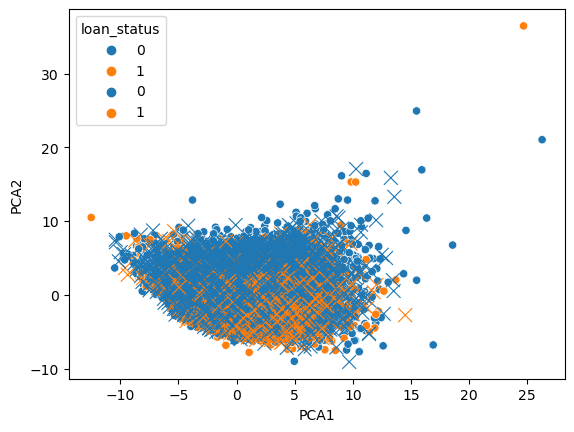

In [126]:
# Create a DataFrame for the transformed data
train_pca_df = pd.DataFrame(X_train_pca, columns=['PCA1', 'PCA2'])
test_pca_df = pd.DataFrame(X_test_pca, columns=['PCA1', 'PCA2'])

# Add the target variable to the DataFrame
train_pca_df['loan_status'] = y_train.values
test_pca_df['loan_status'] = y_test.values

# Plot the transformed data
import seaborn as sns

sns.scatterplot(x='PCA1', y='PCA2', hue='loan_status', data=train_pca_df)
sns.scatterplot(x='PCA1', y='PCA2', hue='loan_status', data=test_pca_df, marker='x', s=100)

In [156]:
from sklearn.metrics import accuracy_score

# Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_pca, y_train)
rfc_pred = rfc.predict(X_test_pca)
rfc_acc = accuracy_score(y_test, rfc_pred)

# Logistic Regression
logis_model = LogisticRegression(random_state=42)
logis_model.fit(X_train_pca, y_train)
logis_model_pred = logis_model.predict(X_test_pca)
logis_model_acc = accuracy_score(y_test, logis_model_pred)

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, y_train)
knn_pred = knn.predict(X_test_pca)
knn_acc = accuracy_score(y_test, knn_pred)

# Compare model accuracies
print("Random Forest Classifier accuracy:", rfc_acc)
print("Logistic Regression accuracy:", logis_model_acc)
print("K-Nearest Neighbors accuracy:", knn_acc)


Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


Random Forest Classifier accuracy: 0.7372164668217102
Logistic Regression accuracy: 0.7685674589990636
K-Nearest Neighbors accuracy: 0.7309190854450451


Accuracy: 0.7762541907034342
Precision: 0.5963748894783377
Recall: 0.08844741673223183
F1 Score: 0.15404819001941303
ROC AUC Score: 0.5352667566728302


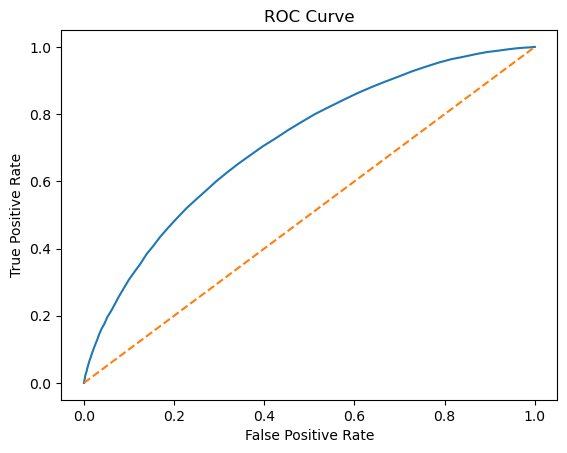

In [163]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(x_train, y_train)

# Make predictions on the test set
y_pred = rfc.predict(x_test)

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred))

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [171]:
# Create a logistic regression model
logis_model = LogisticRegression()

# Fit the model to the training data
logis_model.fit(x_train, y_train)

# Make predictions on the testing data
y_pred = logis_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('ROC AUC Score:', roc_auc)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.7704551632486635
Precision: 0.540625
Recall: 0.022685549436139523
F1 Score: 0.04354392146992197
ROC AUC Score: 0.5084584989263655


In [166]:
from xgboost import XGBClassifier

In [169]:
# Define models
models = [('Random Forest', RandomForestClassifier()),
          ('XGBoost', XGBClassifier()),
          ('KNN', KNeighborsClassifier())]

# Evaluate models
for name, model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f'{name}:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 score: {f1:.4f}')
    print(f'ROC AUC score: {roc_auc:.4f}')
    print('-'*50)

Random Forest:
Accuracy: 0.7755
Precision: 0.5861
Recall: 0.0868
F1 score: 0.1512
ROC AUC score: 0.5342
--------------------------------------------------
XGBoost:
Accuracy: 0.7774
Precision: 0.5546
Recall: 0.1707
F1 score: 0.2611
ROC AUC score: 0.5649
--------------------------------------------------


Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


KNN:
Accuracy: 0.7328
Precision: 0.3135
Recall: 0.1345
F1 score: 0.1882
ROC AUC score: 0.5232
--------------------------------------------------


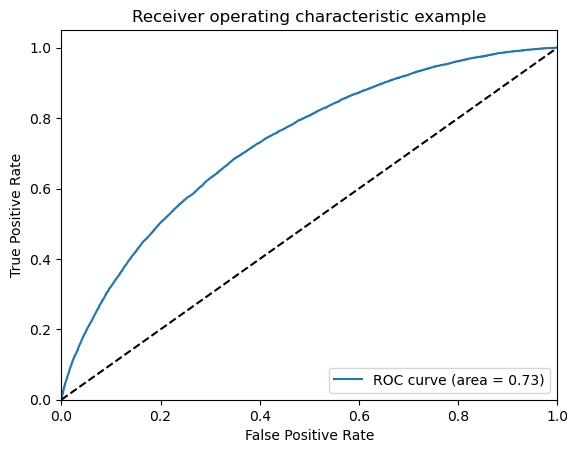

In [170]:
# Train an XGBoost model on the training data
model = xgb.XGBClassifier(random_state=42)
model.fit(x_train, y_train)

# Generate predicted probabilities for the test set
y_pred_prob = model.predict_proba(x_test)[:, 1]

# Compute the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


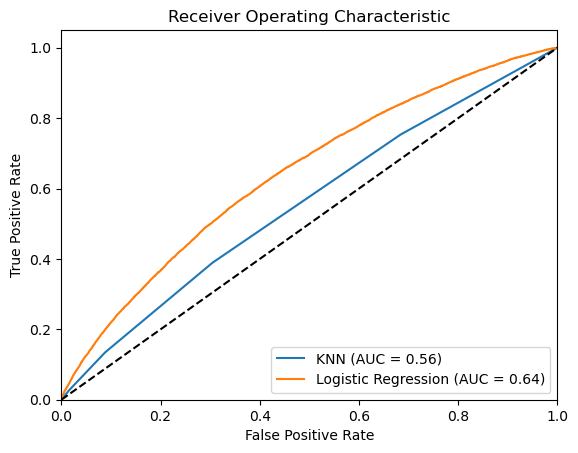

In [175]:
# Instantiate models
KNN = KNeighborsClassifier(n_neighbors=5)
logis_model = LogisticRegression()

# Train models on the training set
KNN.fit(x_train, y_train)
logis_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_KNN = KNN.predict_proba(x_test)[:, 1]
y_pred_logis_model = logis_model.predict_proba(x_test)[:, 1]

# Calculate ROC curve and AUC score for KNN model
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(y_test, y_pred_KNN)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)

# Calculate ROC curve and AUC score for logistic regression model
fpr_logis_model, tpr_logis_model, thresholds_logis_model = roc_curve(y_test, y_pred_logis_model)
roc_auc_logis_model = auc(fpr_logis_model, tpr_logis_model)

# Plot ROC curves
plt.plot(fpr_KNN, tpr_KNN, label='KNN (AUC = %0.2f)' % roc_auc_KNN)
plt.plot(fpr_logis_model, tpr_logis_model, label='Logistic Regression (AUC = %0.2f)' % roc_auc_logis_model)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

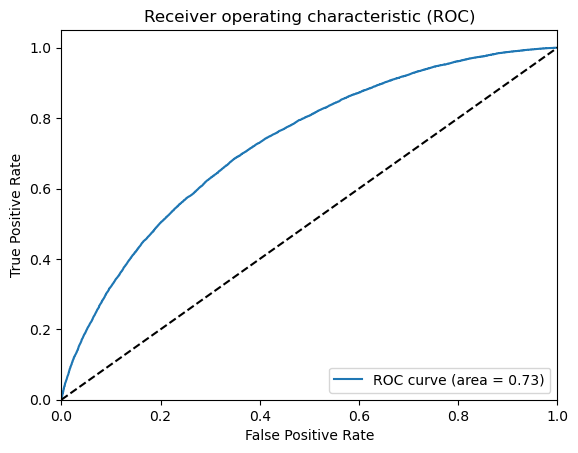

In [176]:
# create and train the XGBoost model
xgb_1st = XGBClassifier()
xgb_1st.fit(x_train, y_train)

# predict the probabilities of the test set
y_pred_proba = xgb_1st.predict_proba(x_test)[:,1]

# calculate the false positive rate, true positive rate and threshold values for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# calculate the AUC score
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


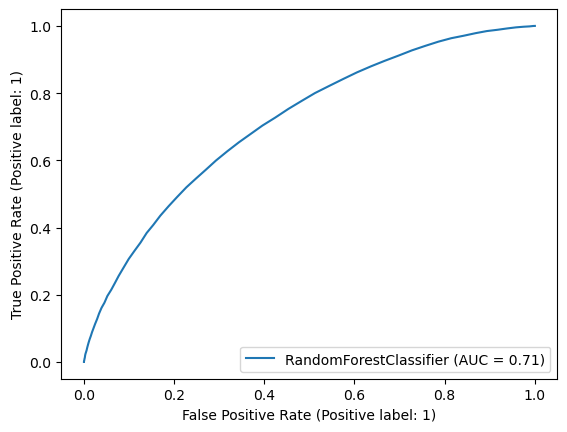

In [177]:
# Instantiate a Random Forest Classifier model
rfc = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rfc.fit(x_train, y_train)

# Predict the probabilities of the positive class
y_pred_proba = rfc.predict_proba(x_test)[:, 1]

# Compute the fpr, tpr, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
roc_auc = plot_roc_curve(rfc, x_test, y_test)
plt.show()

In [180]:
from sklearn.calibration import calibration_curve

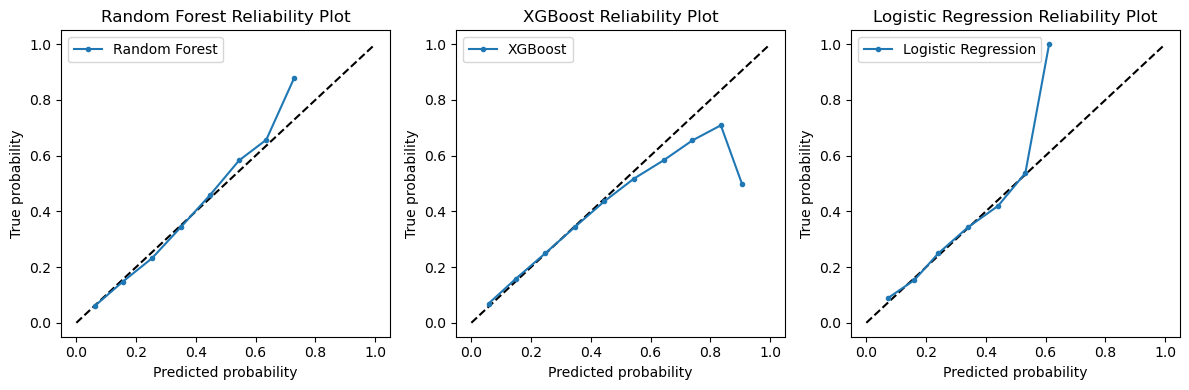

In [181]:
rfc_probs = rfc.predict_proba(x_test)[:, 1]

# Train and predict using XGBoost
xgb_1st_probs = xgb_1st.predict_proba(x_test)[:, 1]


logis_model_probs = logis_model.predict_proba(x_test)[:, 1]

# Create reliability plots
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

for i, (name, probs) in enumerate([('Random Forest', rfc_probs),
                                   ('XGBoost', xgb_1st_probs),
                                   ('Logistic Regression', logis_model_probs)]):

    # Calculate calibration curve
    true_probs, predicted_probs = calibration_curve(y_test, probs, n_bins=10)

    # Plot reliability curve
    ax[i].plot([0, 1], [0, 1], linestyle='--', color='black')
    ax[i].plot(predicted_probs, true_probs, marker='.', label=name)

    # Add axis labels and legend
    ax[i].set_xlabel('Predicted probability')
    ax[i].set_ylabel('True probability')
    ax[i].set_title(f'{name} Reliability Plot')
    ax[i].legend()

plt.tight_layout()
plt.show()

In [193]:
y = y.map({'Charged Off': 0, 'Fully Paid': 1})

In [194]:
# assuming X and y are the feature matrix and target vector respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# perform PCA to reduce dimensionality
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# train Random Forest classifier on PCA-transformed data
rf = RandomForestClassifier()
rf.fit(X_train_pca, y_train)

# train XGBoost classifier on PCA-transformed data
xgb = XGBClassifier()
xgb.fit(X_train_pca, y_train)

# train Logistic Regression classifier on PCA-transformed data
lr = LogisticRegression()
lr.fit(X_train_pca, y_train)

# create confusion matrices for each classifier on the test data
rf_cm = confusion_matrix(y_test, rf.predict(X_test_pca))
xgb_cm = confusion_matrix(y_test, xgb.predict(X_test_pca))
lr_cm = confusion_matrix(y_test, lr.predict(X_test_pca))

# print the confusion matrices
print("Random Forest confusion matrix:\n", rf_cm)
print("XGBoost confusion matrix:\n", xgb_cm)
print("Logistic Regression confusion matrix:\n", lr_cm)

Random Forest confusion matrix:
 [[ 1021  9094]
 [ 3035 30996]]
XGBoost confusion matrix:
 [[   11 10104]
 [   15 34016]]
Logistic Regression confusion matrix:
 [[ 6906  3209]
 [20305 13726]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


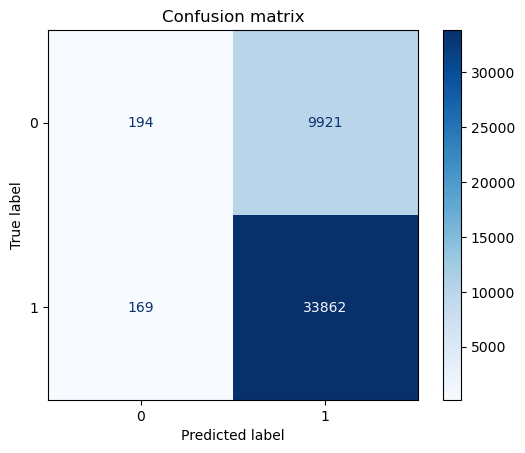

In [198]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


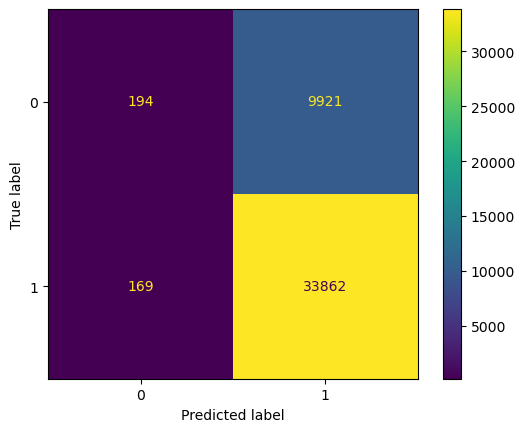

In [197]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

# Train a logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict probabilities
y_proba = clf.predict_proba(X_test)[:, 1]

# Convert to binary predictions using threshold of 0.5
y_pred = (y_proba > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plot_confusion_matrix(clf, X_test, y_test)

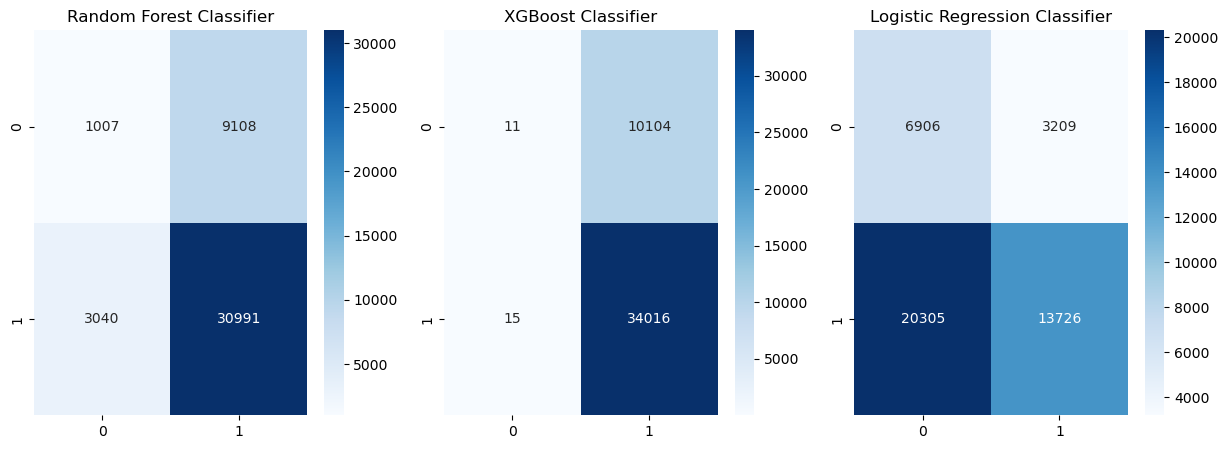

In [199]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a random forest classifier
rfc = RandomForestClassifier()
rfc.fit(X_train_pca, y_train)

# Train an XGBoost classifier
xgb = XGBClassifier()
xgb.fit(X_train_pca, y_train)

# Train a logistic regression classifier
lr = LogisticRegression()
lr.fit(X_train_pca, y_train)

# Predict using the three classifiers
rfc_pred = rfc.predict(X_test_pca)
xgb_pred = xgb.predict(X_test_pca)
lr_pred = lr.predict(X_test_pca)

# Compute confusion matrices
rfc_cm = confusion_matrix(y_test, rfc_pred)
xgb_cm = confusion_matrix(y_test, xgb_pred)
lr_cm = confusion_matrix(y_test, lr_pred)

# Plot the confusion matrices
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.heatmap(rfc_cm, annot=True, cmap="Blues", fmt="d", ax=ax[0])
ax[0].set_title("Random Forest Classifier")

sns.heatmap(xgb_cm, annot=True, cmap="Blues", fmt="d", ax=ax[1])
ax[1].set_title("XGBoost Classifier")

sns.heatmap(lr_cm, annot=True, cmap="Blues", fmt="d", ax=ax[2])
ax[2].set_title("Logistic Regression Classifier")

plt.show()